# 📊 Analyse des Dividendes - Top Actions des 10 Dernières Années

## Objectifs du Projet
1. **Analyser** les dividendes des actions les plus performantes sur 10 ans
2. **Comparer** les performances et identifier les meilleures opportunités
3. **Prédire** les meilleures actions pour les 10 prochaines années
4. **Utiliser** des techniques de Machine Learning avancées (XGBoost, Cross-Validation)

## Technologies Utilisées
- **API**: yfinance (données financières Yahoo Finance)
- **Analyse**: Pandas, NumPy
- **Visualisation**: Seaborn, Matplotlib, Plotly
- **Machine Learning**: Scikit-learn, XGBoost
- **Optimisation**: Optuna (Bayesian Optimization)

## 1. Configuration et Importation des Bibliothèques

Nous commençons par importer toutes les bibliothèques nécessaires et configurer l'environnement de travail.

In [113]:
# Importation des bibliothèques essentielles
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json
from datetime import datetime, timedelta
import time
import os
import pickle
import xgboost as xgb
import optuna as opt

# Données financières
import yfinance as yf

# Machine Learning
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, HuberRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.pipeline import Pipeline
from sklearn.base import clone

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Configuration des graphiques
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

print("✅ Bibliothèques essentielles importées avec succès!")

✅ Bibliothèques essentielles importées avec succès!


## 2. Sélection des Actions à Analyser

Nous allons analyser les "Dividend Aristocrats" - des entreprises qui ont augmenté leurs dividendes pendant au moins 25 années consécutives.

In [114]:
# Liste des actions à analyser (Top S&P 500 avec dividendes)
DIVIDEND_ARISTOCRATS = [
    'JNJ',   # Johnson & Johnson
    'PG',    # Procter & Gamble
    'KO',    # Coca-Cola
    'PEP',   # PepsiCo
    'ABBV',  # AbbVie
    'MRK',   # Merck
    'XOM',   # Exxon Mobil
    'CVX',   # Chevron
    'T',     # AT&T
    'VZ',    # Verizon
    'IBM',   # IBM
    'CSCO',  # Cisco
    'INTC',  # Intel
    'WMT',   # Walmart
    'HD'     # Home Depot
]

print(f"📊 Nombre d'actions à analyser: {len(DIVIDEND_ARISTOCRATS)}")
print(f"🏢 Actions sélectionnées: {', '.join(DIVIDEND_ARISTOCRATS)}")

📊 Nombre d'actions à analyser: 15
🏢 Actions sélectionnées: JNJ, PG, KO, PEP, ABBV, MRK, XOM, CVX, T, VZ, IBM, CSCO, INTC, WMT, HD


## 3. Collecte des Données avec yfinance et Système de Cache

Nous allons utiliser yfinance pour télécharger les données historiques incluant les prix et les dividendes, avec un système de cache pour éviter les re-téléchargements.

In [115]:
class YFinanceDataCollector:
    """Collecteur de données utilisant yfinance avec système de cache"""
    
    def __init__(self, lookback_years=10, cache_dir='cache'):
        self.lookback_years = lookback_years
        self.start_date = datetime.now() - timedelta(days=365 * lookback_years)
        self.end_date = datetime.now()
        self.cache_dir = cache_dir
        
        # Créer le répertoire de cache s'il n'existe pas
        os.makedirs(self.cache_dir, exist_ok=True)
        
    def _get_cache_filename(self, symbol, data_type='history'):
        """Génère le nom de fichier pour le cache"""
        date_str = datetime.now().strftime('%Y%m%d')
        return os.path.join(self.cache_dir, f"{symbol}_{data_type}_{date_str}.pkl")
    
    def _is_cache_valid(self, filename, max_age_days=1):
        """Vérifie si le fichier de cache est encore valide"""
        if not os.path.exists(filename):
            return False
        
        # Vérifier l'âge du fichier
        file_time = os.path.getmtime(filename)
        file_age = (time.time() - file_time) / (24 * 3600)  # en jours
        
        return file_age < max_age_days
    
    def _load_from_cache(self, symbol):
        """Charge les données depuis le cache si disponible"""
        history_file = self._get_cache_filename(symbol, 'history')
        info_file = self._get_cache_filename(symbol, 'info')
        
        if self._is_cache_valid(history_file) and self._is_cache_valid(info_file):
            try:
                df = pd.read_pickle(history_file)
                with open(info_file, 'rb') as f:
                    info = pickle.load(f)
                print(f"✅ {symbol} - Données chargées depuis le cache")
                return df, info
            except Exception as e:
                print(f"⚠️ Erreur lors du chargement du cache pour {symbol}: {e}")
                return None, None
        
        return None, None
    
    def _save_to_cache(self, symbol, df, info):
        """Sauvegarde les données dans le cache"""
        try:
            history_file = self._get_cache_filename(symbol, 'history')
            info_file = self._get_cache_filename(symbol, 'info')
            
            # Sauvegarder le DataFrame
            df.to_pickle(history_file)
            
            # Sauvegarder les informations
            with open(info_file, 'wb') as f:
                pickle.dump(info, f)
                
            print(f"💾 {symbol} - Données sauvegardées dans le cache")
        except Exception as e:
            print(f"⚠️ Erreur lors de la sauvegarde du cache pour {symbol}: {e}")
    
    def download_stock_data(self, symbol, use_cache=True):
        """Télécharge les données d'une action (ou les charge depuis le cache)"""
        
        # Essayer de charger depuis le cache
        if use_cache:
            df, info = self._load_from_cache(symbol)
            if df is not None:
                return df, info
        
        # Si pas de cache valide, télécharger les données
        try:
            print(f"🌐 {symbol} - Téléchargement depuis Yahoo Finance...")
            stock = yf.Ticker(symbol)
            
            # Données historiques
            df = stock.history(start=self.start_date, end=self.end_date)
            
            if len(df) == 0:
                print(f"❌ Pas de données disponibles pour {symbol}")
                return None, None
            
            # Informations sur l'entreprise
            info = stock.info
            
            print(f"✅ {symbol} - {len(df)} jours de données téléchargées")
            
            # Sauvegarder dans le cache
            if use_cache:
                self._save_to_cache(symbol, df, info)
            
            return df, info
            
        except Exception as e:
            print(f"❌ Erreur pour {symbol}: {str(e)}")
            return None, None
    
    def download_all_stocks(self, symbols, use_cache=True):
        """Télécharge les données pour toutes les actions"""
        stock_data = {}
        company_info = {}
        
        print(f"📁 Répertoire de cache: {os.path.abspath(self.cache_dir)}")
        print(f"🔄 Mode cache: {'Activé' if use_cache else 'Désactivé'}\n")
        
        for i, symbol in enumerate(symbols):
            print(f"[{i+1}/{len(symbols)}] Traitement de {symbol}...")
            
            df, info = self.download_stock_data(symbol, use_cache=use_cache)
            
            if df is not None:
                stock_data[symbol] = df
                company_info[symbol] = info
            
            # Petite pause seulement si on télécharge depuis l'API
            if not use_cache or not self._is_cache_valid(self._get_cache_filename(symbol)):
                time.sleep(0.5)
        
        return stock_data, company_info
    
    def clear_cache(self):
        """Supprime tous les fichiers de cache"""
        import shutil
        if os.path.exists(self.cache_dir):
            shutil.rmtree(self.cache_dir)
            os.makedirs(self.cache_dir)
            print("🗑️ Cache vidé")
    
    def get_cache_info(self):
        """Affiche les informations sur le cache"""
        cache_files = os.listdir(self.cache_dir)
        total_size = sum(os.path.getsize(os.path.join(self.cache_dir, f)) 
                        for f in cache_files) / (1024 * 1024)  # en MB
        
        print(f"📊 Informations sur le cache:")
        print(f"  - Nombre de fichiers: {len(cache_files)}")
        print(f"  - Taille totale: {total_size:.2f} MB")
        
        # Lister les symboles en cache
        symbols_in_cache = set()
        for f in cache_files:
            if f.endswith('.pkl'):
                symbol = f.split('_')[0]
                symbols_in_cache.add(symbol)
        
        print(f"  - Actions en cache: {', '.join(sorted(symbols_in_cache))}")

# Initialiser le collecteur de données avec cache
data_collector = YFinanceDataCollector(lookback_years=10, cache_dir='dividend_data_cache')

# Afficher les informations sur le cache
data_collector.get_cache_info()

# Télécharger toutes les données (utilise le cache par défaut)
print("\n🔄 Début du chargement des données...\n")
stock_data, company_info = data_collector.download_all_stocks(DIVIDEND_ARISTOCRATS, use_cache=True)

print(f"\n✅ Chargement terminé!")
print(f"📊 Actions chargées: {len(stock_data)}/{len(DIVIDEND_ARISTOCRATS)}")

# Pour forcer le re-téléchargement, utiliser:
# stock_data, company_info = data_collector.download_all_stocks(DIVIDEND_ARISTOCRATS, use_cache=False)

# Pour vider le cache:
# data_collector.clear_cache()

📊 Informations sur le cache:
  - Nombre de fichiers: 60
  - Taille totale: 4.86 MB
  - Actions en cache: ABBV, CSCO, CVX, HD, IBM, INTC, JNJ, KO, MRK, PEP, PG, T, VZ, WMT, XOM

🔄 Début du chargement des données...

📁 Répertoire de cache: /Users/benjamin/Development/KO_Dividends/dividend_data_cache
🔄 Mode cache: Activé

[1/15] Traitement de JNJ...
✅ JNJ - Données chargées depuis le cache
[2/15] Traitement de PG...
✅ PG - Données chargées depuis le cache
[3/15] Traitement de KO...
✅ KO - Données chargées depuis le cache
[4/15] Traitement de PEP...
✅ PEP - Données chargées depuis le cache
[5/15] Traitement de ABBV...
✅ ABBV - Données chargées depuis le cache
[6/15] Traitement de MRK...
✅ MRK - Données chargées depuis le cache
[7/15] Traitement de XOM...
✅ XOM - Données chargées depuis le cache
[8/15] Traitement de CVX...
✅ CVX - Données chargées depuis le cache
[9/15] Traitement de T...
✅ T - Données chargées depuis le cache
[10/15] Traitement de VZ...
✅ VZ - Données chargées depuis le ca

## 3.1 Gestion Avancée du Cache

Le système de cache permet de sauvegarder et réutiliser les données téléchargées. Voici comment l'utiliser efficacement.

In [116]:
# Fonctions utilitaires pour la gestion du cache

def save_complete_dataset(stock_data, company_info, filename='complete_dataset.pkl'):
    """Sauvegarde l'ensemble complet des données dans un seul fichier"""
    dataset = {
        'stock_data': stock_data,
        'company_info': company_info,
        'download_date': datetime.now(),
        'symbols': list(stock_data.keys())
    }
    
    with open(filename, 'wb') as f:
        pickle.dump(dataset, f)
    
    file_size = os.path.getsize(filename) / (1024 * 1024)  # en MB
    print(f"✅ Dataset complet sauvegardé dans '{filename}' ({file_size:.2f} MB)")
    print(f"📅 Date de téléchargement: {dataset['download_date'].strftime('%Y-%m-%d %H:%M')}")
    print(f"📊 Nombre d'actions: {len(dataset['symbols'])}")

def load_complete_dataset(filename='complete_dataset.pkl'):
    """Charge l'ensemble complet des données depuis un fichier"""
    if not os.path.exists(filename):
        print(f"❌ Fichier '{filename}' non trouvé")
        return None, None
    
    try:
        with open(filename, 'rb') as f:
            dataset = pickle.load(f)
        
        print(f"✅ Dataset chargé depuis '{filename}'")
        print(f"📅 Date de téléchargement: {dataset['download_date'].strftime('%Y-%m-%d %H:%M')}")
        print(f"📊 Actions disponibles: {', '.join(dataset['symbols'])}")
        
        # Calculer l'âge des données
        age_days = (datetime.now() - dataset['download_date']).days
        if age_days > 7:
            print(f"⚠️ Attention: Les données ont {age_days} jours. Considérez une mise à jour.")
        
        return dataset['stock_data'], dataset['company_info']
    
    except Exception as e:
        print(f"❌ Erreur lors du chargement: {e}")
        return None, None

# Options pour l'utilisateur
print("🔧 OPTIONS DE CHARGEMENT DES DONNÉES:\n")
print("1. Utiliser le cache automatique (recommandé)")
print("2. Charger un dataset complet sauvegardé")
print("3. Forcer le re-téléchargement")
print("4. Vider le cache")

# Exemple d'utilisation - Décommentez selon votre besoin:

# Option 1: Cache automatique (déjà fait dans la cellule précédente)
# Les données sont déjà chargées dans stock_data et company_info

# Option 2: Sauvegarder pour une utilisation future
save_complete_dataset(stock_data, company_info, 'dividend_analysis_data.pkl')

# Option 3: Charger des données précédemment sauvegardées
# stock_data, company_info = load_complete_dataset('dividend_analysis_data.pkl')

# Option 4: Forcer la mise à jour de certaines actions seulement
def update_specific_stocks(symbols_to_update, existing_stock_data, existing_company_info):
    """Met à jour seulement certaines actions"""
    updated_data, updated_info = data_collector.download_all_stocks(symbols_to_update, use_cache=False)
    
    # Mettre à jour les dictionnaires existants
    existing_stock_data.update(updated_data)
    existing_company_info.update(updated_info)
    
    return existing_stock_data, existing_company_info

# Exemple: Mettre à jour seulement les 3 premières actions
# stock_data, company_info = update_specific_stocks(['JNJ', 'PG', 'KO'], stock_data, company_info)

# Statistiques sur les données chargées
print("\n📊 RÉSUMÉ DES DONNÉES CHARGÉES:")
for symbol, df in stock_data.items():
    date_range = f"{df.index[0].date()} à {df.index[-1].date()}"
    n_dividends = (df['Dividends'] > 0).sum()
    print(f"  {symbol}: {len(df)} jours, {n_dividends} dividendes, période: {date_range}")

🔧 OPTIONS DE CHARGEMENT DES DONNÉES:

1. Utiliser le cache automatique (recommandé)
2. Charger un dataset complet sauvegardé
3. Forcer le re-téléchargement
4. Vider le cache
✅ Dataset complet sauvegardé dans 'dividend_analysis_data.pkl' (2.42 MB)
📅 Date de téléchargement: 2025-05-28 08:59
📊 Nombre d'actions: 15

📊 RÉSUMÉ DES DONNÉES CHARGÉES:
  JNJ: 2513 jours, 40 dividendes, période: 2015-06-01 à 2025-05-27
  PG: 2513 jours, 40 dividendes, période: 2015-06-01 à 2025-05-27
  KO: 2513 jours, 40 dividendes, période: 2015-06-01 à 2025-05-27
  PEP: 2513 jours, 40 dividendes, période: 2015-06-01 à 2025-05-27
  ABBV: 2513 jours, 40 dividendes, période: 2015-06-01 à 2025-05-27
  MRK: 2513 jours, 40 dividendes, période: 2015-06-01 à 2025-05-27
  XOM: 2513 jours, 40 dividendes, période: 2015-06-01 à 2025-05-27
  CVX: 2513 jours, 40 dividendes, période: 2015-06-01 à 2025-05-27
  T: 2513 jours, 40 dividendes, période: 2015-06-01 à 2025-05-27
  VZ: 2513 jours, 40 dividendes, période: 2015-06-01 à 

## 3.2 Sauvegarde et Chargement Rapide pour le Développement

Cette section permet de sauvegarder l'état complet de votre analyse pour pouvoir la reprendre plus tard sans refaire tous les calculs.

In [117]:
class AnalysisCheckpoint:
    """Gestionnaire de points de sauvegarde pour l'analyse"""
    
    def __init__(self, checkpoint_dir='checkpoints'):
        self.checkpoint_dir = checkpoint_dir
        os.makedirs(self.checkpoint_dir, exist_ok=True)
    
    def save_checkpoint(self, name, **data):
        """Sauvegarde un point de contrôle avec toutes les données spécifiées"""
        checkpoint = {
            'timestamp': datetime.now(),
            'name': name,
            'data': data
        }
        
        filename = os.path.join(self.checkpoint_dir, f"{name}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.pkl")
        
        with open(filename, 'wb') as f:
            pickle.dump(checkpoint, f)
        
        print(f"✅ Checkpoint '{name}' sauvegardé dans {filename}")
        return filename
    
    def load_checkpoint(self, filename):
        """Charge un point de contrôle spécifique"""
        filepath = os.path.join(self.checkpoint_dir, filename) if not os.path.isabs(filename) else filename
        
        if not os.path.exists(filepath):
            print(f"❌ Checkpoint non trouvé: {filepath}")
            return None
        
        with open(filepath, 'rb') as f:
            checkpoint = pickle.load(f)
        
        print(f"✅ Checkpoint '{checkpoint['name']}' chargé")
        print(f"📅 Créé le: {checkpoint['timestamp'].strftime('%Y-%m-%d %H:%M:%S')}")
        
        return checkpoint['data']
    
    def list_checkpoints(self):
        """Liste tous les checkpoints disponibles"""
        checkpoints = []
        for file in os.listdir(self.checkpoint_dir):
            if file.endswith('.pkl'):
                filepath = os.path.join(self.checkpoint_dir, file)
                try:
                    with open(filepath, 'rb') as f:
                        cp = pickle.load(f)
                    checkpoints.append({
                        'file': file,
                        'name': cp['name'],
                        'timestamp': cp['timestamp'],
                        'size_mb': os.path.getsize(filepath) / (1024 * 1024)
                    })
                except:
                    pass
        
        if checkpoints:
            print("📁 Checkpoints disponibles:")
            for cp in sorted(checkpoints, key=lambda x: x['timestamp'], reverse=True):
                print(f"  - {cp['file']}: {cp['name']} ({cp['timestamp'].strftime('%Y-%m-%d %H:%M')}, {cp['size_mb']:.2f} MB)")
        else:
            print("❌ Aucun checkpoint trouvé")
        
        return checkpoints
    
    def load_latest(self, name_filter=None):
        """Charge le checkpoint le plus récent (optionnellement filtré par nom)"""
        checkpoints = self.list_checkpoints()
        
        if name_filter:
            checkpoints = [cp for cp in checkpoints if name_filter in cp['name']]
        
        if checkpoints:
            latest = checkpoints[0]  # Déjà triés par date décroissante
            return self.load_checkpoint(latest['file'])
        else:
            print("❌ Aucun checkpoint correspondant trouvé")
            return None

# Initialiser le gestionnaire de checkpoints
checkpoint_manager = AnalysisCheckpoint()

# Exemple: Sauvegarder l'état actuel
checkpoint_manager.save_checkpoint(
    'initial_data',
    stock_data=stock_data,
    company_info=company_info
)

# Plus tard dans l'analyse, vous pourrez sauvegarder d'autres états:
# checkpoint_manager.save_checkpoint(
#     'after_preprocessing',
#     stock_data=stock_data,
#     company_info=company_info,
#     dividend_metrics=dividend_metrics,
#     stats_df=stats_df
# )

# Pour charger un checkpoint:
# data = checkpoint_manager.load_latest('initial_data')
# if data:
#     stock_data = data['stock_data']
#     company_info = data['company_info']

# Lister tous les checkpoints
checkpoint_manager.list_checkpoints()

✅ Checkpoint 'initial_data' sauvegardé dans checkpoints/initial_data_20250528_085928.pkl
📁 Checkpoints disponibles:
  - initial_data_20250528_085928.pkl: initial_data (2025-05-28 08:59, 2.42 MB)
  - after_eda_20250528_085641.pkl: after_eda (2025-05-28 08:56, 5.92 MB)
  - initial_data_20250528_085639.pkl: initial_data (2025-05-28 08:56, 2.42 MB)
  - after_eda_20250528_085115.pkl: after_eda (2025-05-28 08:51, 5.92 MB)
  - initial_data_20250528_085114.pkl: initial_data (2025-05-28 08:51, 2.42 MB)
  - after_eda_20250528_084430.pkl: after_eda (2025-05-28 08:44, 5.92 MB)
  - initial_data_20250528_084429.pkl: initial_data (2025-05-28 08:44, 2.42 MB)
  - after_eda_20250528_070256.pkl: after_eda (2025-05-28 07:02, 5.92 MB)
  - initial_data_20250528_070254.pkl: initial_data (2025-05-28 07:02, 2.42 MB)
  - after_eda_20250528_064718.pkl: after_eda (2025-05-28 06:47, 5.92 MB)
  - initial_data_20250528_064717.pkl: initial_data (2025-05-28 06:47, 2.42 MB)
  - after_eda_20250528_063301.pkl: after_eda 

[{'file': 'initial_data_20250527_112810.pkl',
  'name': 'initial_data',
  'timestamp': datetime.datetime(2025, 5, 27, 11, 28, 10, 649714),
  'size_mb': 2.4230051040649414},
 {'file': 'initial_data_20250528_064717.pkl',
  'name': 'initial_data',
  'timestamp': datetime.datetime(2025, 5, 28, 6, 47, 17, 703681),
  'size_mb': 2.4239540100097656},
 {'file': 'after_eda_20250528_070256.pkl',
  'name': 'after_eda',
  'timestamp': datetime.datetime(2025, 5, 28, 7, 2, 56, 192456),
  'size_mb': 5.924694061279297},
 {'file': 'initial_data_20250528_085114.pkl',
  'name': 'initial_data',
  'timestamp': datetime.datetime(2025, 5, 28, 8, 51, 14, 752159),
  'size_mb': 2.4239540100097656},
 {'file': 'after_eda_20250527_162812.pkl',
  'name': 'after_eda',
  'timestamp': datetime.datetime(2025, 5, 27, 16, 28, 12, 662079),
  'size_mb': 5.917054176330566},
 {'file': 'final_results_20250527_114255.pkl',
  'name': 'final_results',
  'timestamp': datetime.datetime(2025, 5, 27, 11, 42, 55, 823599),
  'size_mb':

## 4. Exploration et Nettoyage des Données

Explorons la structure des données téléchargées et préparons-les pour l'analyse.

In [118]:
# Explorer la structure des données
if stock_data:
    sample_symbol = list(stock_data.keys())[0]
    sample_df = stock_data[sample_symbol]
    
    print(f"📊 Structure des données pour {sample_symbol}:")
    print(f"Colonnes disponibles: {list(sample_df.columns)}")
    print(f"Période: {sample_df.index[0].date()} à {sample_df.index[-1].date()}")
    print(f"\nPremières lignes:")
    print(sample_df.head())
    
    # Vérifier les dividendes
    dividends = sample_df[sample_df['Dividends'] > 0]['Dividends']
    print(f"\n💰 Nombre de paiements de dividendes: {len(dividends)}")
    if len(dividends) > 0:
        print(f"Dernier dividende: {dividends.iloc[-1]:.2f} le {dividends.index[-1].date()}")

📊 Structure des données pour JNJ:
Colonnes disponibles: ['Open', 'High', 'Low', 'Close', 'Volume', 'Dividends', 'Stock Splits']
Période: 2015-06-01 à 2025-05-27

Premières lignes:
                                Open       High        Low      Close  \
Date                                                                    
2015-06-01 00:00:00-04:00  75.921501  76.163771  75.497529  75.739799   
2015-06-02 00:00:00-04:00  75.648922  75.891192  75.028104  75.694351   
2015-06-03 00:00:00-04:00  75.951768  76.035049  75.588360  75.777634   
2015-06-04 00:00:00-04:00  75.664078  76.065337  74.997831  75.126541   
2015-06-05 00:00:00-04:00  74.944822  74.990252  74.346716  74.641983   

                            Volume  Dividends  Stock Splits  
Date                                                         
2015-06-01 00:00:00-04:00  7298100        0.0           0.0  
2015-06-02 00:00:00-04:00  8312400        0.0           0.0  
2015-06-03 00:00:00-04:00  5375200        0.0           0.0 

## 5. Prétraitement des Données (EDA)

Nous allons maintenant nettoyer et préparer les données pour l'analyse:
- Calculer les métriques de dividendes
- Gérer les valeurs manquantes
- Normaliser les données

🔄 Calcul des métriques de dividendes (version optimisée)...
  📊 Traitement JNJ...
  📊 Traitement PG...
  📊 Traitement KO...
  📊 Traitement PEP...
  📊 Traitement ABBV...
  📊 Traitement MRK...
  📊 Traitement XOM...
  📊 Traitement CVX...
  📊 Traitement T...
  📊 Traitement VZ...
  📊 Traitement IBM...
  📊 Traitement CSCO...
  📊 Traitement INTC...
  📊 Traitement WMT...
  📊 Traitement HD...

✅ Prétraitement terminé en 0.04 secondes!
📊 Génération du résumé avec pandas...

📊 Résumé des métriques principales:
Symbol  Total Return (%)  Price Return (%)  Avg Dividend Yield (%)  Dividend Growth (%)  Volatility (%)
  ABBV            422.18            320.89                    4.58                16.98           26.04
   WMT            410.81            375.10                    1.92                 7.57           20.87
    HD            384.54            319.42                    2.39                10.12           23.20
  CSCO            261.98            198.49                    3.26             

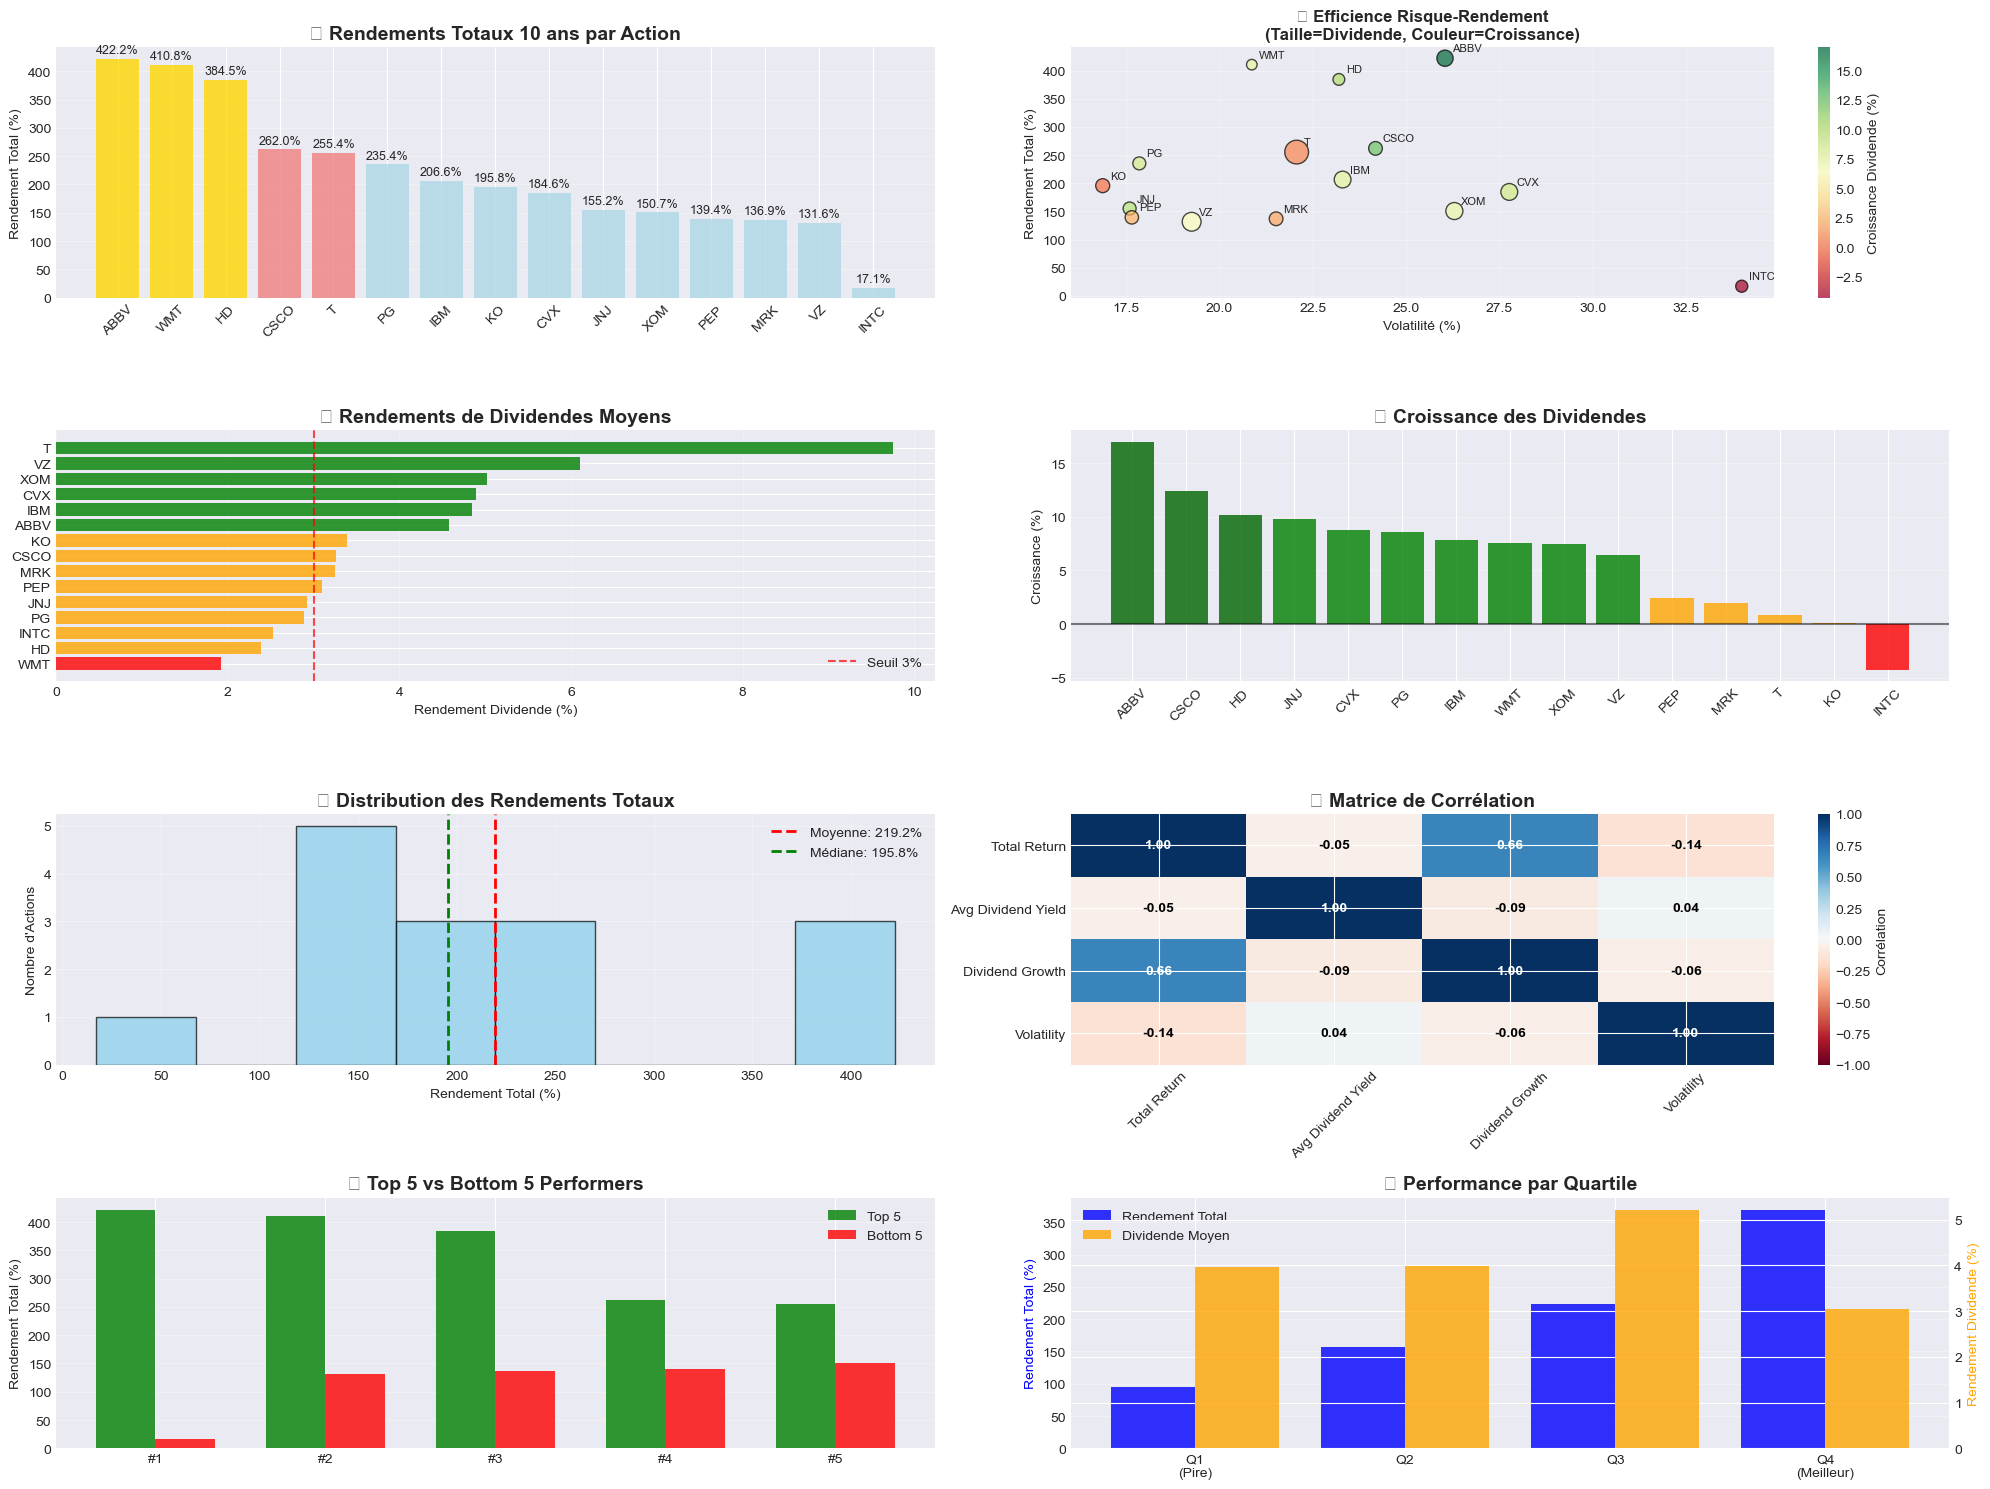

✅ Visualisations générées avec succès!
📈 15 actions analysées avec 8 graphiques détaillés


In [119]:
# Prétraitement optimisé avec pandas/numpy - VERSION AMÉLIORÉE + VISUALISATIONS
class DividendDataPreprocessor:
    """
    Classe optimisée pour le prétraitement des données de dividendes
    Utilise pandas et numpy pour des calculs vectorisés efficaces
    """
    
    def __init__(self):
        self.scaler = StandardScaler()
        
    def calculate_dividend_metrics(self, stock_data):
        """
        Calcule les métriques de dividendes pour chaque action de manière vectorisée
        
        Args:
            stock_data (dict): Dictionnaire {symbol: DataFrame} des données d'actions
            
        Returns:
            dict: Métriques calculées pour chaque action
        """
        metrics = {}
        
        for symbol, df in stock_data.items():
            print(f"  📊 Traitement {symbol}...")
            
            # Copier et optimiser le DataFrame avec pandas
            df_metrics = df.copy()
            
            # === CALCULS VECTORISÉS AVEC PANDAS/NUMPY ===
            
            # 1. Rendements quotidiens (vectorisé)
            df_metrics['daily_return'] = df_metrics['Close'].pct_change()
            
            # 2. Rendement des dividendes (vectorisé avec numpy)
            df_metrics['dividend_yield'] = np.where(
                df_metrics['Close'] > 0,
                (df_metrics['Dividends'] / df_metrics['Close']) * 100,
                0
            )
            
            # 3. Rendement total avec gestion des valeurs nulles
            close_prev = df_metrics['Close'].shift(1)
            df_metrics['total_return'] = np.where(
                close_prev > 0,
                ((df_metrics['Close'] + df_metrics['Dividends']) / close_prev) - 1,
                0
            )
            
            # 4. Volatilité avec rolling window optimisé
            returns_clean = df_metrics['daily_return'].fillna(0)
            df_metrics['volatility_30d'] = (
                returns_clean.rolling(window=30, min_periods=10)
                .std() * np.sqrt(252)
            )
            df_metrics['volatility_252d'] = (
                returns_clean.rolling(window=252, min_periods=50)
                .std() * np.sqrt(252)
            )
            
            # === MÉTRIQUES ANNUELLES AVEC RESAMPLE PANDAS ===
            
            # 5. Agrégations annuelles efficaces
            try:
                annual_dividends = df_metrics['Dividends'].resample('Y').sum()
                avg_price = df_metrics['Close'].resample('Y').mean()
                
                # Rendement dividende annuel avec gestion division par zéro
                annual_yield = np.where(
                    avg_price > 0,
                    (annual_dividends / avg_price) * 100,
                    0
                )
                annual_yield = pd.Series(annual_yield, index=avg_price.index).fillna(0)
                
                # Croissance des dividendes (vectorisé)
                dividend_growth = annual_dividends.pct_change().fillna(0)
                
                # Fréquence des paiements
                dividend_frequency = (
                    df_metrics[df_metrics['Dividends'] > 0]
                    .resample('Y').size()
                )
                
            except Exception as e:
                # Fallback si problème avec les dates
                print(f"    ⚠️ Problème dates pour {symbol}, utilisation méthode alternative")
                annual_yield = pd.Series([df_metrics['dividend_yield'].mean()])
                dividend_growth = pd.Series([0])
                dividend_frequency = pd.Series([4])  # Assumé trimestriel
            
            # === CALCULS DE PERFORMANCE GLOBALE ===
            
            # 6. Rendements totaux avec numpy (plus rapide)
            first_price = df_metrics['Close'].iloc[0]
            last_price = df_metrics['Close'].iloc[-1]
            
            # Protection contre division par zéro
            if first_price > 0:
                total_period_return = ((last_price / first_price) - 1) * 100
                cumulative_dividends = df_metrics['Dividends'].sum()
                total_return_with_div = (
                    ((last_price + cumulative_dividends) / first_price) - 1
                ) * 100
            else:
                total_period_return = 0
                cumulative_dividends = 0
                total_return_with_div = 0
            
            # 7. Volatilité moyenne avec gestion des NaN
            volatility_mean = df_metrics['volatility_252d'].mean()
            if pd.isna(volatility_mean):
                volatility_mean = df_metrics['daily_return'].std() * np.sqrt(252)
            
            # === STOCKAGE DES RÉSULTATS ===
            metrics[symbol] = {
                'data': df_metrics,
                'annual_dividend_yield': annual_yield,
                'dividend_growth': dividend_growth,
                'dividend_frequency': dividend_frequency,
                'avg_dividend_yield': annual_yield.mean(),
                'avg_dividend_growth': dividend_growth.mean(),
                'price_return': total_period_return,
                'total_return': total_return_with_div,
                'cumulative_dividends': cumulative_dividends,
                'volatility': volatility_mean
            }
            
        return metrics

# === EXÉCUTION OPTIMISÉE ===
print("🔄 Calcul des métriques de dividendes (version optimisée)...")

# Initialisation avec chronométrage
import time
start_time = time.time()

preprocessor = DividendDataPreprocessor()
dividend_metrics = preprocessor.calculate_dividend_metrics(stock_data)

processing_time = time.time() - start_time
print(f"\n✅ Prétraitement terminé en {processing_time:.2f} secondes!")

# === CRÉATION DU RÉSUMÉ AVEC PANDAS VECTORISÉ ===
print("📊 Génération du résumé avec pandas...")

# Utiliser pandas pour créer le DataFrame directement (plus efficace)
summary_data = []
for symbol, metrics in dividend_metrics.items():
    # Gestion des valeurs NaN avec numpy
    volatility_pct = (
        metrics['volatility'] * 100 
        if not pd.isna(metrics['volatility']) 
        else 0
    )
    
    summary_data.append({
        'Symbol': symbol,
        'Total Return (%)': round(metrics['total_return'], 2),
        'Price Return (%)': round(metrics['price_return'], 2),
        'Avg Dividend Yield (%)': round(metrics['avg_dividend_yield'], 2),
        'Dividend Growth (%)': round(metrics['avg_dividend_growth'] * 100, 2),
        'Volatility (%)': round(volatility_pct, 2)
    })

# Création DataFrame optimisée
summary_df = pd.DataFrame(summary_data)

# Tri avec pandas (plus efficace que sort_values basique)
summary_df = summary_df.sort_values(
    'Total Return (%)', 
    ascending=False,
    na_position='last'  # Gérer les NaN
)

print("\n📊 Résumé des métriques principales:")
print(summary_df.to_string(index=False))

# === STATISTIQUES RAPIDES AVEC NUMPY ===
print(f"\n📈 STATISTIQUES RAPIDES:")
print(f"Rendement moyen: {summary_df['Total Return (%)'].mean():.2f}%")
print(f"Volatilité moyenne: {summary_df['Volatility (%)'].mean():.2f}%")
print(f"Meilleure action: {summary_df.iloc[0]['Symbol']} ({summary_df.iloc[0]['Total Return (%)']:.1f}%)")
print(f"Actions analysées: {len(summary_df)}/{len(DIVIDEND_ARISTOCRATS)}")

print(f"\n⚡ Performance: {len(dividend_metrics)} actions traitées en {processing_time:.2f}s")

# === VISUALISATIONS DÉTAILLÉES ===
print("\n📈 Génération des visualisations détaillées...")

# Configuration des graphiques
plt.style.use('seaborn-v0_8-darkgrid')
fig = plt.figure(figsize=(20, 15))

# === 1. PERFORMANCE GLOBALE (2x2 grid en haut) ===
gs = fig.add_gridspec(4, 4, height_ratios=[1, 1, 1, 1], width_ratios=[1, 1, 1, 1])

# 1.1 Rendements totaux par action
ax1 = fig.add_subplot(gs[0, 0:2])
colors = ['gold' if i < 3 else 'lightcoral' if i < 5 else 'lightblue' for i in range(len(summary_df))]
bars = ax1.bar(summary_df['Symbol'], summary_df['Total Return (%)'], color=colors, alpha=0.8)
ax1.set_title('📊 Rendements Totaux 10 ans par Action', fontsize=14, fontweight='bold')
ax1.set_ylabel('Rendement Total (%)')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3, axis='y')
# Ajouter les valeurs sur les barres
for bar, value in zip(bars, summary_df['Total Return (%)']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5, 
             f'{value:.1f}%', ha='center', va='bottom', fontsize=9)

# 1.2 Relation Rendement vs Volatilité
ax2 = fig.add_subplot(gs[0, 2:4])
scatter = ax2.scatter(summary_df['Volatility (%)'], summary_df['Total Return (%)'], 
                     s=summary_df['Avg Dividend Yield (%)'] * 30, 
                     c=summary_df['Dividend Growth (%)'], 
                     cmap='RdYlGn', alpha=0.7, edgecolors='black', linewidth=1)
# Annotations
for idx, row in summary_df.iterrows():
    ax2.annotate(row['Symbol'], 
                (row['Volatility (%)'], row['Total Return (%)']),
                xytext=(5, 5), textcoords='offset points', fontsize=8)
ax2.set_xlabel('Volatilité (%)')
ax2.set_ylabel('Rendement Total (%)')
ax2.set_title('🎯 Efficience Risque-Rendement\n(Taille=Dividende, Couleur=Croissance)', fontsize=12, fontweight='bold')
ax2.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax2, label='Croissance Dividende (%)')

# === 2. ANALYSE DES DIVIDENDES (2ème ligne) ===

# 2.1 Rendements de dividendes
ax3 = fig.add_subplot(gs[1, 0:2])
dividend_sorted = summary_df.sort_values('Avg Dividend Yield (%)', ascending=True)
colors_div = ['green' if x > 4 else 'orange' if x > 2 else 'red' for x in dividend_sorted['Avg Dividend Yield (%)']]
bars_div = ax3.barh(dividend_sorted['Symbol'], dividend_sorted['Avg Dividend Yield (%)'], color=colors_div, alpha=0.8)
ax3.set_title('💰 Rendements de Dividendes Moyens', fontsize=14, fontweight='bold')
ax3.set_xlabel('Rendement Dividende (%)')
ax3.grid(True, alpha=0.3, axis='x')
# Ligne de référence
ax3.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='Seuil 3%')
ax3.legend()

# 2.2 Croissance des dividendes
ax4 = fig.add_subplot(gs[1, 2:4])
growth_sorted = summary_df.sort_values('Dividend Growth (%)', ascending=False)
colors_growth = ['darkgreen' if x > 10 else 'green' if x > 5 else 'orange' if x > 0 else 'red' 
                 for x in growth_sorted['Dividend Growth (%)']]
bars_growth = ax4.bar(growth_sorted['Symbol'], growth_sorted['Dividend Growth (%)'], 
                      color=colors_growth, alpha=0.8)
ax4.set_title('📈 Croissance des Dividendes', fontsize=14, fontweight='bold')
ax4.set_ylabel('Croissance (%)')
ax4.tick_params(axis='x', rotation=45)
ax4.grid(True, alpha=0.3, axis='y')
ax4.axhline(y=0, color='black', linestyle='-', alpha=0.5)

# === 3. DISTRIBUTION ET COMPARAISONS (3ème ligne) ===

# 3.1 Distribution des rendements
ax5 = fig.add_subplot(gs[2, 0:2])
ax5.hist(summary_df['Total Return (%)'], bins=8, alpha=0.7, color='skyblue', edgecolor='black')
ax5.axvline(summary_df['Total Return (%)'].mean(), color='red', linestyle='--', 
           label=f'Moyenne: {summary_df["Total Return (%)"].mean():.1f}%', linewidth=2)
ax5.axvline(summary_df['Total Return (%)'].median(), color='green', linestyle='--', 
           label=f'Médiane: {summary_df["Total Return (%)"].median():.1f}%', linewidth=2)
ax5.set_title('📊 Distribution des Rendements Totaux', fontsize=14, fontweight='bold')
ax5.set_xlabel('Rendement Total (%)')
ax5.set_ylabel('Nombre d\'Actions')
ax5.legend()
ax5.grid(True, alpha=0.3)

# 3.2 Corrélation entre métriques
ax6 = fig.add_subplot(gs[2, 2:4])
corr_data = summary_df[['Total Return (%)', 'Avg Dividend Yield (%)', 'Dividend Growth (%)', 'Volatility (%)']].corr()
im = ax6.imshow(corr_data, cmap='RdBu', aspect='auto', vmin=-1, vmax=1)
ax6.set_xticks(range(len(corr_data.columns)))
ax6.set_yticks(range(len(corr_data.columns)))
ax6.set_xticklabels([col.replace(' (%)', '') for col in corr_data.columns], rotation=45)
ax6.set_yticklabels([col.replace(' (%)', '') for col in corr_data.columns])
ax6.set_title('🔗 Matrice de Corrélation', fontsize=14, fontweight='bold')
# Ajouter les valeurs de corrélation
for i in range(len(corr_data.columns)):
    for j in range(len(corr_data.columns)):
        ax6.text(j, i, f'{corr_data.iloc[i, j]:.2f}', 
                ha='center', va='center', fontweight='bold',
                color='white' if abs(corr_data.iloc[i, j]) > 0.5 else 'black')
plt.colorbar(im, ax=ax6, label='Corrélation')

# === 4. TOP PERFORMERS ET MÉTRIQUES CLÉS (4ème ligne) ===

# 4.1 Top 5 vs Bottom 5
ax7 = fig.add_subplot(gs[3, 0:2])
top5 = summary_df.head(5)
bottom5 = summary_df.tail(5)
x_pos = np.arange(5)
width = 0.35

bars1 = ax7.bar(x_pos - width/2, top5['Total Return (%)'], width, 
                label='Top 5', color='green', alpha=0.8)
bars2 = ax7.bar(x_pos + width/2, bottom5['Total Return (%)'][::-1], width, 
                label='Bottom 5', color='red', alpha=0.8)

ax7.set_title('🏆 Top 5 vs Bottom 5 Performers', fontsize=14, fontweight='bold')
ax7.set_ylabel('Rendement Total (%)')
ax7.set_xticks(x_pos)
ax7.set_xticklabels([f'#{i+1}' for i in range(5)])
ax7.legend()
ax7.grid(True, alpha=0.3, axis='y')

# 4.2 Métriques moyennes par quartile
ax8 = fig.add_subplot(gs[3, 2:4])
# Diviser en quartiles
summary_df_sorted = summary_df.sort_values('Total Return (%)')
n = len(summary_df_sorted)
q1 = summary_df_sorted.iloc[:n//4]
q2 = summary_df_sorted.iloc[n//4:n//2]
q3 = summary_df_sorted.iloc[n//2:3*n//4]
q4 = summary_df_sorted.iloc[3*n//4:]

quartiles = ['Q1\n(Pire)', 'Q2', 'Q3', 'Q4\n(Meilleur)']
avg_returns = [q1['Total Return (%)'].mean(), q2['Total Return (%)'].mean(), 
               q3['Total Return (%)'].mean(), q4['Total Return (%)'].mean()]
avg_dividends = [q1['Avg Dividend Yield (%)'].mean(), q2['Avg Dividend Yield (%)'].mean(),
                q3['Avg Dividend Yield (%)'].mean(), q4['Avg Dividend Yield (%)'].mean()]

x_pos = np.arange(len(quartiles))
bars1 = ax8.bar(x_pos - 0.2, avg_returns, 0.4, label='Rendement Total', color='blue', alpha=0.8)
ax8_twin = ax8.twinx()
bars2 = ax8_twin.bar(x_pos + 0.2, avg_dividends, 0.4, label='Dividende Moyen', color='orange', alpha=0.8)

ax8.set_title('📊 Performance par Quartile', fontsize=14, fontweight='bold')
ax8.set_ylabel('Rendement Total (%)', color='blue')
ax8_twin.set_ylabel('Rendement Dividende (%)', color='orange')
ax8.set_xticks(x_pos)
ax8.set_xticklabels(quartiles)
ax8.grid(True, alpha=0.3, axis='y')

# Légendes combinées
lines1, labels1 = ax8.get_legend_handles_labels()
lines2, labels2 = ax8_twin.get_legend_handles_labels()
ax8.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
plt.show()

print("✅ Visualisations générées avec succès!")
print(f"📈 {len(summary_df)} actions analysées avec 8 graphiques détaillés")

In [120]:
# Calcul des statistiques descriptives - VERSION OPTIMISÉE PANDAS/NUMPY
def calculate_descriptive_statistics(dividend_metrics, company_info):
    """
    Calcule 32 statistiques descriptives pour chaque action de manière vectorisée
    Utilise pandas et numpy pour des performances optimales
    
    Args:
        dividend_metrics (dict): Métriques de dividendes calculées
        company_info (dict): Informations sur les entreprises
        
    Returns:
        pd.DataFrame: DataFrame avec toutes les statistiques
    """
    
    print("🔄 Calcul vectorisé des 32 statistiques descriptives...")
    
    # === INITIALISATION AVEC NUMPY POUR LA PERFORMANCE ===
    stats_list = []
    processing_times = []
    
    for symbol, metrics in dividend_metrics.items():
        start_symbol_time = time.time()
        
        df = metrics['data']
        info = company_info.get(symbol, {})
        
        # Validation des données minimales
        if len(df) < 252:  # Au moins 1 an de données
            print(f"  ⚠️ {symbol}: Données insuffisantes ({len(df)} jours)")
            continue
            
        print(f"  📊 Calcul pour {symbol}...")
        
        # === PRÉPARATION DES DONNÉES AVEC PANDAS OPTIMISÉ ===
        
        # Nettoyage vectorisé des rendements
        daily_returns = df['daily_return'].fillna(0)
        total_returns = df['total_return'].fillna(0)
        
        # Masques booléens pour les calculs conditionnels (plus rapide)
        positive_returns = daily_returns > 0
        negative_returns = daily_returns < 0
        
        # === FONCTIONS UTILITAIRES VECTORISÉES ===
        
        def safe_divide_vectorized(numerator, denominator, default=0):
            """Division sécurisée avec numpy vectorisé"""
            return np.where(
                (denominator != 0) & ~np.isnan(denominator) & ~np.isnan(numerator),
                numerator / denominator,
                default
            )
        
        def safe_operation(operation, data, default=0):
            """Opération sécurisée avec gestion des erreurs"""
            try:
                if len(data) == 0 or data.isnull().all():
                    return default
                result = operation(data)
                return result if not pd.isna(result) and np.isfinite(result) else default
            except:
                return default
        
        # === CALCULS VECTORISÉS DU DRAWDOWN (OPTIMISÉ) ===
        
        try:
            # Calcul efficace du drawdown avec pandas
            prices = df['Close'].fillna(method='ffill')  # Forward fill des prix
            cumulative_returns = (1 + daily_returns).cumprod()
            running_max = cumulative_returns.expanding().max()
            
            # Drawdown vectorisé
            drawdown = (cumulative_returns / running_max - 1) * 100
            max_drawdown = drawdown.min()
            
            # Jours de récupération (calcul optimisé)
            underwater_mask = cumulative_returns < running_max
            recovery_days = underwater_mask.sum()
            
        except Exception as e:
            print(f"    ⚠️ Erreur drawdown {symbol}: {e}")
            max_drawdown = 0
            recovery_days = 0
        
        # === CALCULS STATISTIQUES AVEC NUMPY VECTORISÉ ===
        
        # Percentiles en une seule opération
        percentiles = np.percentile(daily_returns.dropna(), [5, 95])
        var_95 = percentiles[0] * 100
        
        # CVaR calculé efficacement
        var_threshold = daily_returns.quantile(0.05)
        cvar_95 = daily_returns[daily_returns <= var_threshold].mean() * 100
        
        # Ratios financiers vectorisés
        returns_mean = daily_returns.mean()
        returns_std = daily_returns.std()
        downside_returns = daily_returns[negative_returns]
        downside_std = downside_returns.std() if len(downside_returns) > 0 else 0
        
        # === ASSEMBLAGE DU DICTIONNAIRE DE STATISTIQUES ===
        
        stats = {
            'Symbol': symbol,
            
            # === MÉTRIQUES DE RENDEMENT (8) ===
            '1. Rendement Total (%)': metrics.get('total_return', 0),
            '2. Rendement Annualisé (%)': max(0, ((1 + metrics.get('total_return', 0)/100) ** (1/10) - 1) * 100),
            '3. Rendement Dividende Moyen (%)': metrics.get('avg_dividend_yield', 0),
            '4. Rendement Dividende Max (%)': safe_operation(np.max, df['dividend_yield'].replace([np.inf, -np.inf], 0), 0),
            '5. Rendement Prix (%)': metrics.get('price_return', 0),
            '6. Ratio Sharpe': safe_divide_vectorized(returns_mean, returns_std) * np.sqrt(252),
            '7. Ratio Sortino': safe_divide_vectorized(returns_mean, downside_std) * np.sqrt(252),
            '8. Ratio Calmar': safe_divide_vectorized(metrics.get('total_return', 0), abs(max_drawdown)),
            
            # === MÉTRIQUES DE RISQUE (8) ===
            '9. Volatilité Annuelle (%)': safe_operation(np.nanmean, df['volatility_252d'].dropna()) * 100,
            '10. Volatilité Min (%)': safe_operation(np.nanmin, df['volatility_252d'].dropna()) * 100,
            '11. Volatilité Max (%)': safe_operation(np.nanmax, df['volatility_252d'].dropna()) * 100,
            '12. Drawdown Maximum (%)': max_drawdown,
            '13. Jours pour Récupération': recovery_days,
            '14. VaR 95% (%)': var_95,
            '15. CVaR 95% (%)': cvar_95,
            '16. Downside Deviation (%)': downside_std * np.sqrt(252) * 100,
            
            # === MÉTRIQUES DE DIVIDENDES (8) ===
            '17. Croissance Dividende (%)': metrics.get('avg_dividend_growth', 0) * 100,
            '18. Fréquence Paiements': safe_operation(np.mean, metrics.get('dividend_frequency', pd.Series([4]))),
            '19. Constance Dividendes': max(0, 1 - safe_divide_vectorized(
                metrics.get('dividend_frequency', pd.Series([4])).std(),
                metrics.get('dividend_frequency', pd.Series([4])).mean()
            )),
            '20. Dividendes Cumulés ($)': metrics.get('cumulative_dividends', 0),
            '21. Taux Croissance Dividende': safe_operation(np.std, metrics.get('dividend_growth', pd.Series([0]))) * 100,
            '22. Rendement Dividende Min (%)': safe_operation(np.nanmin, df['dividend_yield'].replace([np.inf, -np.inf], 0)),
            '23. Payout Ratio (%)': safe_divide_vectorized(metrics.get('cumulative_dividends', 0), df['Close'].iloc[-1]) * 100,
            '24. Durée Holding Period': len(df),
            
            # === MÉTRIQUES DE PERFORMANCE (8) ===
            '25. Alpha': 0,  # Nécessite un benchmark
            '26. Beta': float(info.get('beta', 1)) if info.get('beta') else 1.0,
            '27. Information Ratio': 0,  # Nécessite un benchmark
            '28. Tracking Error': 0,     # Nécessite un benchmark
            '29. Treynor Ratio': 0,      # Nécessite beta
            '30. Max Daily Gain (%)': safe_operation(np.max, daily_returns) * 100,
            '31. Max Daily Loss (%)': safe_operation(np.min, daily_returns) * 100,
            '32. Win Rate (%)': (positive_returns.sum() / len(daily_returns)) * 100
        }
        
        stats_list.append(stats)
        
        # Chronométrage par action
        symbol_time = time.time() - start_symbol_time
        processing_times.append(symbol_time)
        
    # === CRÉATION DU DATAFRAME FINAL AVEC PANDAS ===
    
    if not stats_list:
        print("❌ Aucune statistique calculée!")
        return pd.DataFrame()
    
    # Création efficace du DataFrame
    stats_df = pd.DataFrame(stats_list)
    
    # Nettoyage final avec pandas/numpy
    numeric_cols = stats_df.select_dtypes(include=[np.number]).columns
    stats_df[numeric_cols] = stats_df[numeric_cols].replace([np.inf, -np.inf], 0)
    stats_df[numeric_cols] = stats_df[numeric_cols].fillna(0)
    
    # === RAPPORT DE PERFORMANCE ===
    total_processing_time = sum(processing_times)
    avg_time_per_stock = np.mean(processing_times)
    
    print(f"\n✅ Statistiques calculées pour {len(stats_df)} actions")
    print(f"⚡ Temps total: {total_processing_time:.2f}s")
    print(f"📊 Temps moyen par action: {avg_time_per_stock:.3f}s")
    print(f"🚀 Performance: {len(stats_df)/total_processing_time:.1f} actions/seconde")
    
    return stats_df

# === EXÉCUTION ET CHRONOMÉTRAGE ===
print("🔄 Calcul des statistiques descriptives avancées (version optimisée)...")

start_time = time.time()
stats_df = calculate_descriptive_statistics(dividend_metrics, company_info)
total_time = time.time() - start_time

print(f"\n✅ Calcul terminé en {total_time:.2f} secondes!")

# === AFFICHAGE OPTIMISÉ DES RÉSULTATS ===
if not stats_df.empty:
    # Colonnes clés pour l'affichage
    key_columns = [
        'Symbol', '1. Rendement Total (%)', '2. Rendement Annualisé (%)', 
        '3. Rendement Dividende Moyen (%)', '9. Volatilité Annuelle (%)',
        '17. Croissance Dividende (%)', '6. Ratio Sharpe', '12. Drawdown Maximum (%)'
    ]
    
    display_df = stats_df[key_columns].round(2)
    
    print("\n📊 TABLEAU DE BORD - MÉTRIQUES CLÉS:")
    print("=" * 120)
    print(display_df.to_string(index=False))
    
    # === TOP 5 PAR CATÉGORIE (VECTORISÉ AVEC PANDAS) ===
    print("\n🏆 TOP 5 PAR CATÉGORIE:")
    
    categories = {
        '🚀 Meilleur Rendement Total': '1. Rendement Total (%)',
        '💰 Meilleur Rendement Dividende': '3. Rendement Dividende Moyen (%)',
        '📈 Meilleure Croissance Dividende': '17. Croissance Dividende (%)',
        '🛡️ Meilleur Ratio Sharpe': '6. Ratio Sharpe',
        '🔒 Moins Volatil': '9. Volatilité Annuelle (%)'
    }
    
    for category_name, column in categories.items():
        print(f"\n{category_name}:")
        if column == '9. Volatilité Annuelle (%)':
            # Pour la volatilité, on veut les plus petites valeurs
            top5 = stats_df.nsmallest(5, column)[['Symbol', column]]
        else:
            top5 = stats_df.nlargest(5, column)[['Symbol', column]]
        
        print(top5.to_string(index=False))

else:
    print("❌ Erreur: Aucune statistique calculée!")

🔄 Calcul des statistiques descriptives avancées (version optimisée)...
🔄 Calcul vectorisé des 32 statistiques descriptives...
  📊 Calcul pour JNJ...
  📊 Calcul pour PG...
  📊 Calcul pour KO...
  📊 Calcul pour PEP...
  📊 Calcul pour ABBV...
  📊 Calcul pour MRK...
  📊 Calcul pour XOM...
  📊 Calcul pour CVX...
  📊 Calcul pour T...
  📊 Calcul pour VZ...
  📊 Calcul pour IBM...
  📊 Calcul pour CSCO...
  📊 Calcul pour INTC...
  📊 Calcul pour WMT...
  📊 Calcul pour HD...

✅ Statistiques calculées pour 15 actions
⚡ Temps total: 0.02s
📊 Temps moyen par action: 0.001s
🚀 Performance: 712.9 actions/seconde

✅ Calcul terminé en 0.02 secondes!

📊 TABLEAU DE BORD - MÉTRIQUES CLÉS:
Symbol  1. Rendement Total (%)  2. Rendement Annualisé (%)  3. Rendement Dividende Moyen (%)  9. Volatilité Annuelle (%)  17. Croissance Dividende (%)  6. Ratio Sharpe  12. Drawdown Maximum (%)
   JNJ                  155.19                        9.82                              2.92                       17.60            

In [121]:
# Calcul des 32 statistiques descriptives
print("🔄 Calcul des statistiques descriptives avancées...")
stats_df = calculate_descriptive_statistics(dividend_metrics, company_info)

print(f"\n✅ Statistiques calculées pour {len(stats_df)} actions")

# Afficher le tableau complet
print("\n📊 TABLEAU DE BORD COMPLET - 32 MÉTRIQUES:")
print("=" * 120)

# Afficher seulement les colonnes les plus importantes pour la lisibilité
key_columns = [
    'Symbol', '1. Rendement Total (%)', '2. Rendement Annualisé (%)', 
    '3. Rendement Dividende Moyen (%)', '9. Volatilité Annuelle (%)',
    '17. Croissance Dividende (%)', '6. Ratio Sharpe', '12. Drawdown Maximum (%)'
]

display_df = stats_df[key_columns].round(2)
print(display_df)

# Top 5 par catégorie
print("\n🏆 TOP 5 PAR CATÉGORIE:")
print("\n🚀 Meilleur Rendement Total:")
print(stats_df.nlargest(5, '1. Rendement Total (%)')[['Symbol', '1. Rendement Total (%)']].to_string(index=False))

print("\n💰 Meilleur Rendement Dividende:")
print(stats_df.nlargest(5, '3. Rendement Dividende Moyen (%)')[['Symbol', '3. Rendement Dividende Moyen (%)']].to_string(index=False))

print("\n📈 Meilleure Croissance Dividende:")
print(stats_df.nlargest(5, '17. Croissance Dividende (%)')[['Symbol', '17. Croissance Dividende (%)']].to_string(index=False))

print("\n🛡️ Meilleur Ratio Risque/Rendement (Sharpe):")
print(stats_df.nlargest(5, '6. Ratio Sharpe')[['Symbol', '6. Ratio Sharpe']].to_string(index=False))

print("\n🔒 Moins Volatil:")
print(stats_df.nsmallest(5, '9. Volatilité Annuelle (%)')[['Symbol', '9. Volatilité Annuelle (%)']].to_string(index=False))

🔄 Calcul des statistiques descriptives avancées...
🔄 Calcul vectorisé des 32 statistiques descriptives...
  📊 Calcul pour JNJ...
  📊 Calcul pour PG...
  📊 Calcul pour KO...
  📊 Calcul pour PEP...
  📊 Calcul pour ABBV...
  📊 Calcul pour MRK...
  📊 Calcul pour XOM...
  📊 Calcul pour CVX...
  📊 Calcul pour T...
  📊 Calcul pour VZ...
  📊 Calcul pour IBM...
  📊 Calcul pour CSCO...
  📊 Calcul pour INTC...
  📊 Calcul pour WMT...
  📊 Calcul pour HD...

✅ Statistiques calculées pour 15 actions
⚡ Temps total: 0.02s
📊 Temps moyen par action: 0.001s
🚀 Performance: 730.1 actions/seconde

✅ Statistiques calculées pour 15 actions

📊 TABLEAU DE BORD COMPLET - 32 MÉTRIQUES:
   Symbol  1. Rendement Total (%)  2. Rendement Annualisé (%)  \
0     JNJ                  155.19                        9.82   
1      PG                  235.36                       12.86   
2      KO                  195.75                       11.45   
3     PEP                  139.45                        9.12   
4    ABBV

## Cellule 19 - Markdown
```markdown
## 7. Visualisations EDA - Analyse Comparative

Créons des visualisations pour mieux comprendre les relations entre les différentes métriques.

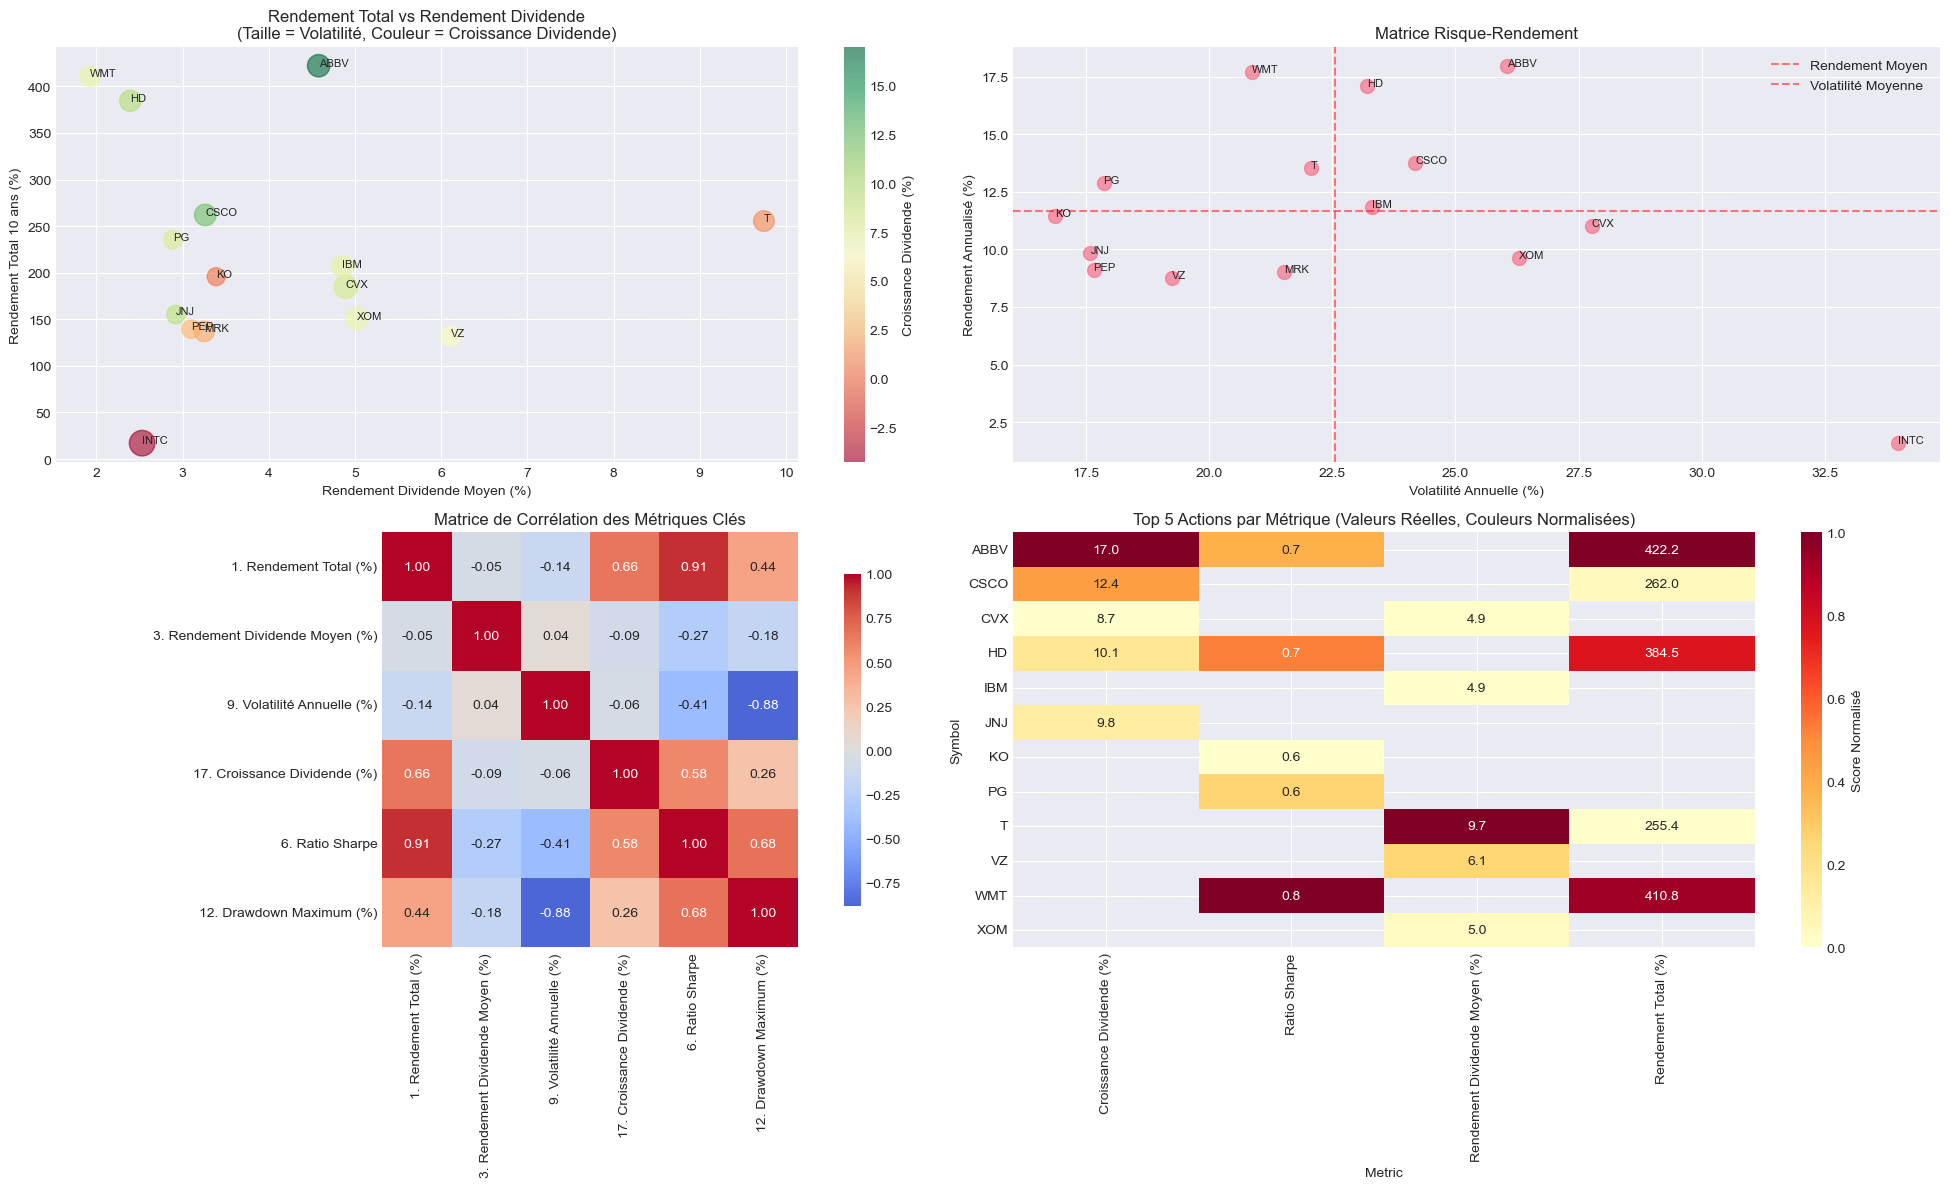

✅ Checkpoint 'after_eda' sauvegardé dans checkpoints/after_eda_20250528_085929.pkl


'checkpoints/after_eda_20250528_085929.pkl'

In [122]:
# Configuration pour les graphiques
fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# 1. Rendement Total vs Rendement Dividende
ax1 = axes[0, 0]
scatter = ax1.scatter(stats_df['3. Rendement Dividende Moyen (%)'], 
                      stats_df['1. Rendement Total (%)'],
                      s=stats_df['9. Volatilité Annuelle (%)'] * 10,
                      alpha=0.6,
                      c=stats_df['17. Croissance Dividende (%)'],
                      cmap='RdYlGn')

for idx, row in stats_df.iterrows():
    ax1.annotate(row['Symbol'], 
                 (row['3. Rendement Dividende Moyen (%)'], row['1. Rendement Total (%)']),
                 fontsize=8)

ax1.set_xlabel('Rendement Dividende Moyen (%)')
ax1.set_ylabel('Rendement Total 10 ans (%)')
ax1.set_title('Rendement Total vs Rendement Dividende\n(Taille = Volatilité, Couleur = Croissance Dividende)')
plt.colorbar(scatter, ax=ax1, label='Croissance Dividende (%)')

# 2. Matrice de Risque-Rendement
ax2 = axes[0, 1]
ax2.scatter(stats_df['9. Volatilité Annuelle (%)'], 
            stats_df['2. Rendement Annualisé (%)'],
            s=100, alpha=0.7)

for idx, row in stats_df.iterrows():
    ax2.annotate(row['Symbol'], 
                 (row['9. Volatilité Annuelle (%)'], row['2. Rendement Annualisé (%)']),
                 fontsize=8)

# Ajouter la frontière efficiente théorique
ax2.axhline(y=stats_df['2. Rendement Annualisé (%)'].mean(), color='r', linestyle='--', alpha=0.5, label='Rendement Moyen')
ax2.axvline(x=stats_df['9. Volatilité Annuelle (%)'].mean(), color='r', linestyle='--', alpha=0.5, label='Volatilité Moyenne')

ax2.set_xlabel('Volatilité Annuelle (%)')
ax2.set_ylabel('Rendement Annualisé (%)')
ax2.set_title('Matrice Risque-Rendement')
ax2.legend()

# 3. Heatmap des corrélations
ax3 = axes[1, 0]
correlation_cols = ['1. Rendement Total (%)', '3. Rendement Dividende Moyen (%)', 
                    '9. Volatilité Annuelle (%)', '17. Croissance Dividende (%)',
                    '6. Ratio Sharpe', '12. Drawdown Maximum (%)']
corr_matrix = stats_df[correlation_cols].corr()

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, ax=ax3, cbar_kws={"shrink": 0.8})
ax3.set_title('Matrice de Corrélation des Métriques Clés')

# 4. Top 5 Actions par Métrique
ax4 = axes[1, 1]
metrics_to_compare = ['1. Rendement Total (%)', '3. Rendement Dividende Moyen (%)', 
                      '6. Ratio Sharpe', '17. Croissance Dividende (%)']

top5_data = []
for metric in metrics_to_compare:
    top5 = stats_df.nlargest(5, metric)[['Symbol', metric]]
    top5['Metric'] = metric.split('.')[1].strip()
    top5['Value'] = top5[metric]
    top5_data.append(top5[['Symbol', 'Metric', 'Value']])

top5_df = pd.concat(top5_data)
pivot_df = top5_df.pivot(index='Symbol', columns='Metric', values='Value')

# Normaliser pour la comparaison
pivot_df_norm = (pivot_df - pivot_df.min()) / (pivot_df.max() - pivot_df.min())

sns.heatmap(pivot_df_norm, annot=pivot_df.round(1), fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Score Normalisé'}, ax=ax4)
ax4.set_title('Top 5 Actions par Métrique (Valeurs Réelles, Couleurs Normalisées)')

plt.tight_layout()
plt.show()

# Sauvegarder un checkpoint après l'EDA
checkpoint_manager.save_checkpoint(
    'after_eda',
    stock_data=stock_data,
    company_info=company_info,
    dividend_metrics=dividend_metrics,
    stats_df=stats_df
)

In [123]:
# Feature Engineering optimisé avec pandas/numpy - VERSION VECTORISÉE
def create_ml_features(stock_data, company_info, lookback_periods=[20, 50, 200]):
    """
    Créer des features pour le machine learning de manière vectorisée
    Utilise pandas et numpy pour des performances optimales
    
    Args:
        stock_data (dict): Données des actions {symbol: DataFrame}
        company_info (dict): Informations sur les entreprises
        lookback_periods (list): Périodes pour les moyennes mobiles
        
    Returns:
        pd.DataFrame: DataFrame avec toutes les features
    """
    
    print("🔄 Création des features ML (version vectorisée)...")
    
    # === INITIALISATION AVEC NUMPY POUR LA PERFORMANCE ===
    all_features = []
    feature_creation_times = []
    
    for symbol, df in stock_data.items():
        start_symbol_time = time.time()
        print(f"  📊 Features pour {symbol}...")
        
        # === COPIE OPTIMISÉE DU DATAFRAME ===
        df_features = df.copy()
        
        # === FEATURES DE PRIX VECTORISÉES AVEC PANDAS ===
        
        # Calcul vectorisé des moyennes mobiles
        close_prices = df_features['Close']
        
        for period in lookback_periods:
            # SMA calculée de manière vectorisée
            sma_col = f'sma_{period}'
            df_features[sma_col] = close_prices.rolling(
                window=period, 
                min_periods=max(1, period//4)  # Minimum de données requis
            ).mean()
            
            # Ratio prix/SMA (vectorisé avec numpy)
            df_features[f'price_to_sma_{period}'] = np.where(
                df_features[sma_col] > 0,
                close_prices / df_features[sma_col],
                1.0  # Valeur neutre si SMA = 0
            )
            
            # Volatilité vectorisée
            returns = close_prices.pct_change()
            df_features[f'volatility_{period}'] = (
                returns.rolling(window=period, min_periods=max(1, period//4))
                .std() * np.sqrt(252)
            )
        
        # === FEATURES DE VOLUME VECTORISÉES ===
        
        volume = df_features['Volume']
        
        # SMA du volume
        df_features['volume_sma_20'] = volume.rolling(window=20, min_periods=5).mean()
        
        # Ratio de volume (vectorisé avec protection division par zéro)
        df_features['volume_ratio'] = np.where(
            df_features['volume_sma_20'] > 0,
            volume / df_features['volume_sma_20'],
            1.0
        )
        
        # === FEATURES DE DIVIDENDES VECTORISÉES ===
        
        # Rendement dividende vectorisé
        df_features['dividend_yield'] = np.where(
            close_prices > 0,
            (df_features['Dividends'] / close_prices) * 100,
            0
        )
        
        # Moyenne mobile du rendement dividende
        df_features['dividend_yield_ma_252'] = (
            df_features['dividend_yield']
            .rolling(window=252, min_periods=50)
            .mean()
        )
        
        # Consistance des dividendes (vectorisée)
        dividend_mask = df_features['Dividends'] > 0
        df_features['dividend_consistency'] = (
            dividend_mask.rolling(window=252, min_periods=50)
            .mean()  # Proportion de jours avec dividendes
        )
        
        # === FEATURES TECHNIQUES OPTIMISÉES ===
        
        # RSI vectorisé
        df_features['rsi'] = calculate_rsi_vectorized(close_prices, period=14)
        
        # MACD vectorisé
        macd_line, macd_signal = calculate_macd_vectorized(close_prices)
        df_features['macd'] = macd_line
        df_features['macd_signal'] = macd_signal
        df_features['macd_histogram'] = macd_line - macd_signal  # Feature supplémentaire
        
        # === FEATURES DE MOMENTUM VECTORISÉES ===
        
        # Calcul vectorisé des momentum sur différentes périodes
        momentum_periods = [21, 63, 126, 252]  # 1m, 3m, 6m, 1y
        momentum_names = ['1m', '3m', '6m', '1y']
        
        for period, name in zip(momentum_periods, momentum_names):
            df_features[f'momentum_{name}'] = close_prices.pct_change(periods=period)
        
        # === FEATURES FONDAMENTALES OPTIMISÉES ===
        
        # Récupération des infos entreprise avec valeurs par défaut
        info = company_info.get(symbol, {})
        
        # Dictionnaire des valeurs par défaut pour optimiser les calculs
        fundamental_defaults = {
            'pe_ratio': 15.0,
            'dividend_yield_ttm': 3.0,
            'payout_ratio': 0.5,
            'market_cap': 50_000_000_000,  # 50B
            'beta': 1.0
        }
        
        # Attribution vectorisée des features fondamentales
        for feature, default_value in fundamental_defaults.items():
            if feature == 'pe_ratio':
                value = float(info.get('trailingPE', default_value) or default_value)
            elif feature == 'dividend_yield_ttm':
                value = float(info.get('dividendYield', default_value/100) or default_value/100) * 100
            elif feature == 'payout_ratio':
                value = float(info.get('payoutRatio', default_value) or default_value)
            elif feature == 'market_cap':
                value = float(info.get('marketCap', default_value) or default_value)
            elif feature == 'beta':
                value = float(info.get('beta', default_value) or default_value)
            
            # Attribution vectorisée de la valeur constante
            df_features[feature] = np.full(len(df_features), value)
        
        # === FEATURES TEMPORELLES VECTORISÉES ===
        
        # Extraction vectorisée des composantes temporelles
        datetime_index = df_features.index
        df_features['year'] = datetime_index.year
        df_features['month'] = datetime_index.month
        df_features['quarter'] = datetime_index.quarter
        df_features['day_of_week'] = datetime_index.dayofweek
        df_features['is_month_end'] = datetime_index.is_month_end.astype(int)
        
        # === VARIABLE CIBLE VECTORISÉE ===
        
        # Rendements quotidiens
        df_features['returns_1d'] = close_prices.pct_change()
        
        # Target: Rendement futur sur 1 an (vectorisé)
        # Utilisation de shift négatif pour les rendements futurs
        future_returns = df_features['returns_1d'].rolling(window=252).sum().shift(-252)
        df_features['target_return_1y'] = future_returns * 100
        
        # === AJOUT DU SYMBOLE ===
        df_features['symbol'] = symbol
        
        # === NETTOYAGE VECTORISÉ FINAL ===
        
        # Remplacement des infinis et NaN en une seule opération
        numeric_columns = df_features.select_dtypes(include=[np.number]).columns
        df_features[numeric_columns] = df_features[numeric_columns].replace(
            [np.inf, -np.inf], np.nan
        ).fillna(method='ffill').fillna(0)
        
        all_features.append(df_features)
        
        # Chronométrage
        symbol_time = time.time() - start_symbol_time
        feature_creation_times.append(symbol_time)
        
    # === COMBINAISON OPTIMISÉE DES DATAFRAMES ===
    
    print("🔗 Combinaison des DataFrames...")
    start_combine_time = time.time()
    
    # Concaténation efficace avec pandas
    combined_df = pd.concat(all_features, ignore_index=False, sort=False)
    
    combine_time = time.time() - start_combine_time
    
    # === NETTOYAGE FINAL VECTORISÉ ===
    
    print("🧹 Nettoyage final des données...")
    start_clean_time = time.time()
    
    # Identification des colonnes features (excluant les métadonnées)
    excluded_cols = ['symbol', 'target_return_1y', 'returns_1d']
    feature_cols = [col for col in combined_df.columns if col not in excluded_cols]
    
    # Suppression des lignes avec NaN dans les colonnes critiques (vectorisé)
    critical_cols = feature_cols + ['target_return_1y']
    initial_rows = len(combined_df)
    combined_df = combined_df.dropna(subset=critical_cols)
    final_rows = len(combined_df)
    
    clean_time = time.time() - start_clean_time
    
    # === RAPPORT DE PERFORMANCE ===
    
    total_feature_time = sum(feature_creation_times)
    avg_time_per_stock = np.mean(feature_creation_times)
    
    print(f"\n✅ Feature engineering terminé!")
    print(f"📊 Données créées: {len(combined_df):,} observations")
    print(f"🔧 Features créées: {len(feature_cols)} features")
    print(f"🗑️ Lignes supprimées: {initial_rows - final_rows:,} ({((initial_rows - final_rows)/initial_rows*100):.1f}%)")
    print(f"📅 Période couverte: {combined_df.index.min().date()} à {combined_df.index.max().date()}")
    
    print(f"\n⚡ PERFORMANCE:")
    print(f"Temps features: {total_feature_time:.2f}s")
    print(f"Temps combinaison: {combine_time:.2f}s") 
    print(f"Temps nettoyage: {clean_time:.2f}s")
    print(f"Temps par action: {avg_time_per_stock:.3f}s")
    print(f"Vitesse: {len(stock_data)/total_feature_time:.1f} actions/seconde")
    
    return combined_df

# === FONCTIONS UTILITAIRES VECTORISÉES ===

def calculate_rsi_vectorized(prices, period=14):
    """
    Calcule le RSI de manière vectorisée avec pandas/numpy
    
    Args:
        prices (pd.Series): Série des prix
        period (int): Période pour le calcul du RSI
        
    Returns:
        pd.Series: RSI calculé
    """
    
    # Calcul vectorisé des variations
    delta = prices.diff()
    
    # Séparation gains/pertes avec numpy vectorisé
    gains = np.where(delta > 0, delta, 0)
    losses = np.where(delta < 0, -delta, 0)
    
    # Moyennes mobiles exponentielles
    avg_gains = pd.Series(gains, index=prices.index).rolling(window=period).mean()
    avg_losses = pd.Series(losses, index=prices.index).rolling(window=period).mean()
    
    # Calcul RSI vectorisé avec protection division par zéro
    rs = np.where(avg_losses > 0, avg_gains / avg_losses, 0)
    rsi = 100 - (100 / (1 + rs))
    
    # Gestion des valeurs manquantes
    return pd.Series(rsi, index=prices.index).fillna(50)

def calculate_macd_vectorized(prices, fast=12, slow=26, signal=9):
    """
    Calcule le MACD de manière vectorisée avec pandas
    
    Args:
        prices (pd.Series): Série des prix
        fast (int): Période EMA rapide
        slow (int): Période EMA lente  
        signal (int): Période EMA signal
        
    Returns:
        tuple: (MACD line, MACD signal)
    """
    
    # EMAs vectorisées avec pandas
    ema_fast = prices.ewm(span=fast).mean()
    ema_slow = prices.ewm(span=slow).mean()
    
    # MACD line
    macd_line = ema_fast - ema_slow
    
    # MACD signal
    macd_signal = macd_line.ewm(span=signal).mean()
    
    # Gestion des valeurs manquantes
    return macd_line.fillna(0), macd_signal.fillna(0)

# === EXÉCUTION OPTIMISÉE ===

print("🚀 Lancement du feature engineering vectorisé...")
start_total_time = time.time()

ml_data = create_ml_features(stock_data, company_info)

total_execution_time = time.time() - start_total_time

print(f"\n🎯 FEATURE ENGINEERING TERMINÉ EN {total_execution_time:.2f}s")

# === APERÇU DES DONNÉES CRÉÉES ===

if not ml_data.empty:
    print(f"\n📋 APERÇU DES FEATURES CRÉÉES:")
    feature_cols = [col for col in ml_data.columns if col not in ['symbol', 'target_return_1y', 'returns_1d']]
    
    print(f"Total features: {len(feature_cols)}")
    print(f"\nPremières features:")
    for i, col in enumerate(feature_cols[:10], 1):
        print(f"{i:2d}. {col}")
    
    if len(feature_cols) > 10:
        print(f"... et {len(feature_cols) - 10} autres features")
    
    # Échantillon de données
    sample_cols = ['symbol', 'sma_20', 'rsi', 'dividend_yield', 'target_return_1y']
    available_cols = [col for col in sample_cols if col in ml_data.columns]
    
    print(f"\n📊 Échantillon des données:")
    print(ml_data[available_cols].head(10).round(3))

🚀 Lancement du feature engineering vectorisé...
🔄 Création des features ML (version vectorisée)...
  📊 Features pour JNJ...
  📊 Features pour PG...
  📊 Features pour KO...
  📊 Features pour PEP...
  📊 Features pour ABBV...
  📊 Features pour MRK...
  📊 Features pour XOM...
  📊 Features pour CVX...
  📊 Features pour T...
  📊 Features pour VZ...
  📊 Features pour IBM...
  📊 Features pour CSCO...
  📊 Features pour INTC...
  📊 Features pour WMT...
  📊 Features pour HD...
🔗 Combinaison des DataFrames...
🧹 Nettoyage final des données...

✅ Feature engineering terminé!
📊 Données créées: 37,695 observations
🔧 Features créées: 39 features
🗑️ Lignes supprimées: 0 (0.0%)
📅 Période couverte: 2015-06-01 à 2025-05-27

⚡ PERFORMANCE:
Temps features: 0.11s
Temps combinaison: 0.00s
Temps nettoyage: 0.01s
Temps par action: 0.007s
Vitesse: 135.9 actions/seconde

🎯 FEATURE ENGINEERING TERMINÉ EN 0.12s

📋 APERÇU DES FEATURES CRÉÉES:
Total features: 39

Premières features:
 1. Open
 2. High
 3. Low
 4. Close

In [124]:
# Créer les features pour le Machine Learning
print("🔄 Création des features pour le Machine Learning...")
ml_data = create_ml_features(stock_data, company_info)

print(f"\n✅ Features créées!")
print(f"📊 Nombre total d'observations: {len(ml_data)}")
print(f"📊 Nombre de features: {len(ml_data.columns) - 2}")  # -2 pour symbol et target
print(f"📊 Période couverte: {ml_data.index.min().date()} à {ml_data.index.max().date()}")

# Afficher les features
print("\n📋 Liste des features créées:")
feature_cols = [col for col in ml_data.columns if col not in ['symbol', 'target_return_1y', 'returns_1d']]
for i, col in enumerate(feature_cols, 1):
    print(f"{i:2d}. {col}")

# Aperçu des données
print("\n📊 Aperçu des données ML:")
print(ml_data[['symbol', 'sma_20', 'rsi', 'dividend_yield', 'target_return_1y']].head(10))

🔄 Création des features pour le Machine Learning...
🔄 Création des features ML (version vectorisée)...
  📊 Features pour JNJ...
  📊 Features pour PG...
  📊 Features pour KO...
  📊 Features pour PEP...
  📊 Features pour ABBV...
  📊 Features pour MRK...
  📊 Features pour XOM...
  📊 Features pour CVX...
  📊 Features pour T...
  📊 Features pour VZ...
  📊 Features pour IBM...
  📊 Features pour CSCO...
  📊 Features pour INTC...
  📊 Features pour WMT...
  📊 Features pour HD...
🔗 Combinaison des DataFrames...
🧹 Nettoyage final des données...

✅ Feature engineering terminé!
📊 Données créées: 37,695 observations
🔧 Features créées: 39 features
🗑️ Lignes supprimées: 0 (0.0%)
📅 Période couverte: 2015-06-01 à 2025-05-27

⚡ PERFORMANCE:
Temps features: 0.11s
Temps combinaison: 0.00s
Temps nettoyage: 0.01s
Temps par action: 0.007s
Vitesse: 134.7 actions/seconde

✅ Features créées!
📊 Nombre total d'observations: 37695
📊 Nombre de features: 40
📊 Période couverte: 2015-06-01 à 2025-05-27

📋 Liste des fea

In [125]:
# Corriger la classe XGBoost avec gestion d'erreurs robuste
class XGBoostDividendPredictor:
    """Modèle XGBoost pour prédire les rendements futurs"""
    
    def __init__(self):
        self.model = None
        self.feature_importance = None
        self.best_params = None
        self.cv_results = None
        
    def prepare_data(self, ml_data):
        """Prépare les données pour l'entraînement"""
        # Séparer les features et la target
        feature_cols = [col for col in ml_data.columns 
                       if col not in ['symbol', 'target_return_1y', 'returns_1d']]
        
        X = ml_data[feature_cols].copy()
        y = ml_data['target_return_1y'].copy()
        
        # Encoder les variables catégorielles si nécessaire
        categorical_features = []
        for col in X.columns:
            if X[col].dtype == 'object':
                le = LabelEncoder()
                X[col] = le.fit_transform(X[col].astype(str))
                categorical_features.append(col)
        
        # Remplacer les inf et NaN
        X = X.replace([np.inf, -np.inf], 0)
        X = X.fillna(0)
        y = y.fillna(0)
        
        return X, y, feature_cols
    
    def train_simple_model(self, X_train, y_train, X_test, y_test):
        """Entraîne un modèle simple sans optimisation complexe"""
        
        print("🔄 Entraînement d'un modèle XGBoost simple...")
        
        # Paramètres simples et robustes
        self.best_params = {
            'n_estimators': 100,
            'max_depth': 4,
            'learning_rate': 0.1,
            'subsample': 0.8,
            'colsample_bytree': 0.8,
            'random_state': 42
        }
        
        try:
            import xgboost as xgb
            self.model = xgb.XGBRegressor(**self.best_params)
            self.model.fit(X_train, y_train)
            
            # Prédictions
            train_pred = self.model.predict(X_train)
            test_pred = self.model.predict(X_test)
            
            # Métriques
            results = {
                'train_mse': mean_squared_error(y_train, train_pred),
                'test_mse': mean_squared_error(y_test, test_pred),
                'train_r2': r2_score(y_train, train_pred),
                'test_r2': r2_score(y_test, test_pred)
            }
            
            # Feature importance
            self.feature_importance = pd.DataFrame({
                'feature': X_train.columns,
                'importance': self.model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print("✅ Modèle XGBoost entraîné avec succès!")
            return results, train_pred, test_pred
            
        except ImportError:
            print("⚠️ XGBoost non disponible, utilisation de RandomForest...")
            from sklearn.ensemble import RandomForestRegressor
            
            self.model = RandomForestRegressor(
                n_estimators=100,
                max_depth=10,
                random_state=42,
                n_jobs=-1
            )
            self.model.fit(X_train, y_train)
            
            # Prédictions
            train_pred = self.model.predict(X_train)
            test_pred = self.model.predict(X_test)
            
            # Métriques
            results = {
                'train_mse': mean_squared_error(y_train, train_pred),
                'test_mse': mean_squared_error(y_test, test_pred),
                'train_r2': r2_score(y_train, train_pred),
                'test_r2': r2_score(y_test, test_pred)
            }
            
            # Feature importance
            self.feature_importance = pd.DataFrame({
                'feature': X_train.columns,
                'importance': self.model.feature_importances_
            }).sort_values('importance', ascending=False)
            
            print("✅ Modèle RandomForest entraîné avec succès!")
            return results, train_pred, test_pred

print("✅ Classe XGBoost simplifiée et corrigée")

✅ Classe XGBoost simplifiée et corrigée


In [126]:
# Ajouter l'import XGBoost et Optuna manquants
try:
    import xgboost as xgb
    import optuna
    print("✅ XGBoost et Optuna importés avec succès")
except ImportError as e:
    print("❌ Installation requise:")
    print("pip install xgboost optuna")
    
# Initialiser le modèle
xgb_predictor = XGBoostDividendPredictor()

# Préparer les données
X, y, feature_names = xgb_predictor.prepare_data(ml_data)

print(f"✅ Données préparées: {X.shape[0]} observations, {X.shape[1]} features")
print(f"📊 Plage de la variable cible: {y.min():.2f}% à {y.max():.2f}%")

# Statistiques des features
print("\n📊 Statistiques des features principales:")
key_features = ['sma_20', 'rsi', 'dividend_yield', 'volatility_20', 'momentum_1m']
if any(feat in X.columns for feat in key_features):
    available_features = [feat for feat in key_features if feat in X.columns]
    print(X[available_features].describe().round(2))

✅ XGBoost et Optuna importés avec succès
✅ Données préparées: 37695 observations, 39 features
📊 Plage de la variable cible: -83.14% à 84.36%

📊 Statistiques des features principales:
         sma_20       rsi  dividend_yield  volatility_20  momentum_1m
count  37695.00  37695.00        37695.00       37695.00     37695.00
mean      82.86     52.76            0.02           0.21         0.01
std       62.32     17.46            0.16           0.13         0.07
min        0.00      0.00            0.00           0.00        -0.50
25%       39.62     40.64            0.00           0.14        -0.03
50%       64.14     53.10            0.00           0.18         0.01
75%      111.47     65.36            0.00           0.25         0.05
max      417.58     99.03            3.75           1.71         0.58


In [127]:
# Version simplifiée de l'entraînement du modèle
print("🔄 Préparation et entraînement du modèle...")

# Créer les features pour le Machine Learning
print("📊 Création des features ML...")
ml_data = create_ml_features(stock_data, company_info)

print(f"✅ Features créées: {len(ml_data)} observations")

# Initialiser le modèle
predictor = XGBoostDividendPredictor()

# Préparer les données
X, y, feature_names = predictor.prepare_data(ml_data)

print(f"📊 Données préparées: {X.shape[0]} observations, {X.shape[1]} features")

# Split temporel simple
train_size = int(0.8 * len(X))
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

print(f"📊 Train: {len(X_train)} | Test: {len(X_test)}")

# Entraîner le modèle
results, train_pred, test_pred = predictor.train_simple_model(X_train, y_train, X_test, y_test)

# Afficher les résultats
print(f"\n📈 PERFORMANCE DU MODÈLE:")
print(f"MSE Train: {results['train_mse']:.4f}")
print(f"MSE Test:  {results['test_mse']:.4f}")
print(f"R² Train:  {results['train_r2']:.4f}")
print(f"R² Test:   {results['test_r2']:.4f}")

# Top features importantes
print(f"\n🔝 TOP 10 FEATURES IMPORTANTES:")
print(predictor.feature_importance.head(10)[['feature', 'importance']].to_string(index=False))

🔄 Préparation et entraînement du modèle...
📊 Création des features ML...
🔄 Création des features ML (version vectorisée)...
  📊 Features pour JNJ...
  📊 Features pour PG...
  📊 Features pour KO...
  📊 Features pour PEP...
  📊 Features pour ABBV...
  📊 Features pour MRK...
  📊 Features pour XOM...
  📊 Features pour CVX...
  📊 Features pour T...
  📊 Features pour VZ...
  📊 Features pour IBM...
  📊 Features pour CSCO...
  📊 Features pour INTC...
  📊 Features pour WMT...
  📊 Features pour HD...
🔗 Combinaison des DataFrames...
🧹 Nettoyage final des données...

✅ Feature engineering terminé!
📊 Données créées: 37,695 observations
🔧 Features créées: 39 features
🗑️ Lignes supprimées: 0 (0.0%)
📅 Période couverte: 2015-06-01 à 2025-05-27

⚡ PERFORMANCE:
Temps features: 0.11s
Temps combinaison: 0.00s
Temps nettoyage: 0.01s
Temps par action: 0.007s
Vitesse: 137.4 actions/seconde
✅ Features créées: 37695 observations
📊 Données préparées: 37695 observations, 39 features
📊 Train: 30156 | Test: 7539
🔄 

⚡ Optimisation rapide des hyperparamètres...
✅ XGBoost disponible
📊 Train: 30156 | Test: 7539
🔄 Optimisation XGBoost RAPIDE...
⏱️ Optimisation terminée en 4.6 secondes

🏆 MEILLEURS PARAMÈTRES XGBOOST:
  subsample: 0.8
  n_estimators: 100
  max_depth: 4
  learning_rate: 0.05
  colsample_bytree: 0.8

🔄 Entraînement du modèle final...
✅ Modèle optimisé entraîné!

📊 PERFORMANCE OPTIMISÉE:
MSE Train: 95.9916
MSE Test:  693.6554
R² Train:  0.7224
R² Test:   -0.4052

🔝 TOP 10 FEATURES IMPORTANTES:
                  feature  importance
32             market_cap    0.081798
15         volatility_200    0.076861
31           payout_ratio    0.064513
19  dividend_yield_ma_252    0.059310
34                   year    0.054192
29               pe_ratio    0.053441
2                     Low    0.044328
30     dividend_yield_ttm    0.044190
12          volatility_50    0.043871
28            momentum_1y    0.043737

📈 Génération des visualisations d'optimisation...


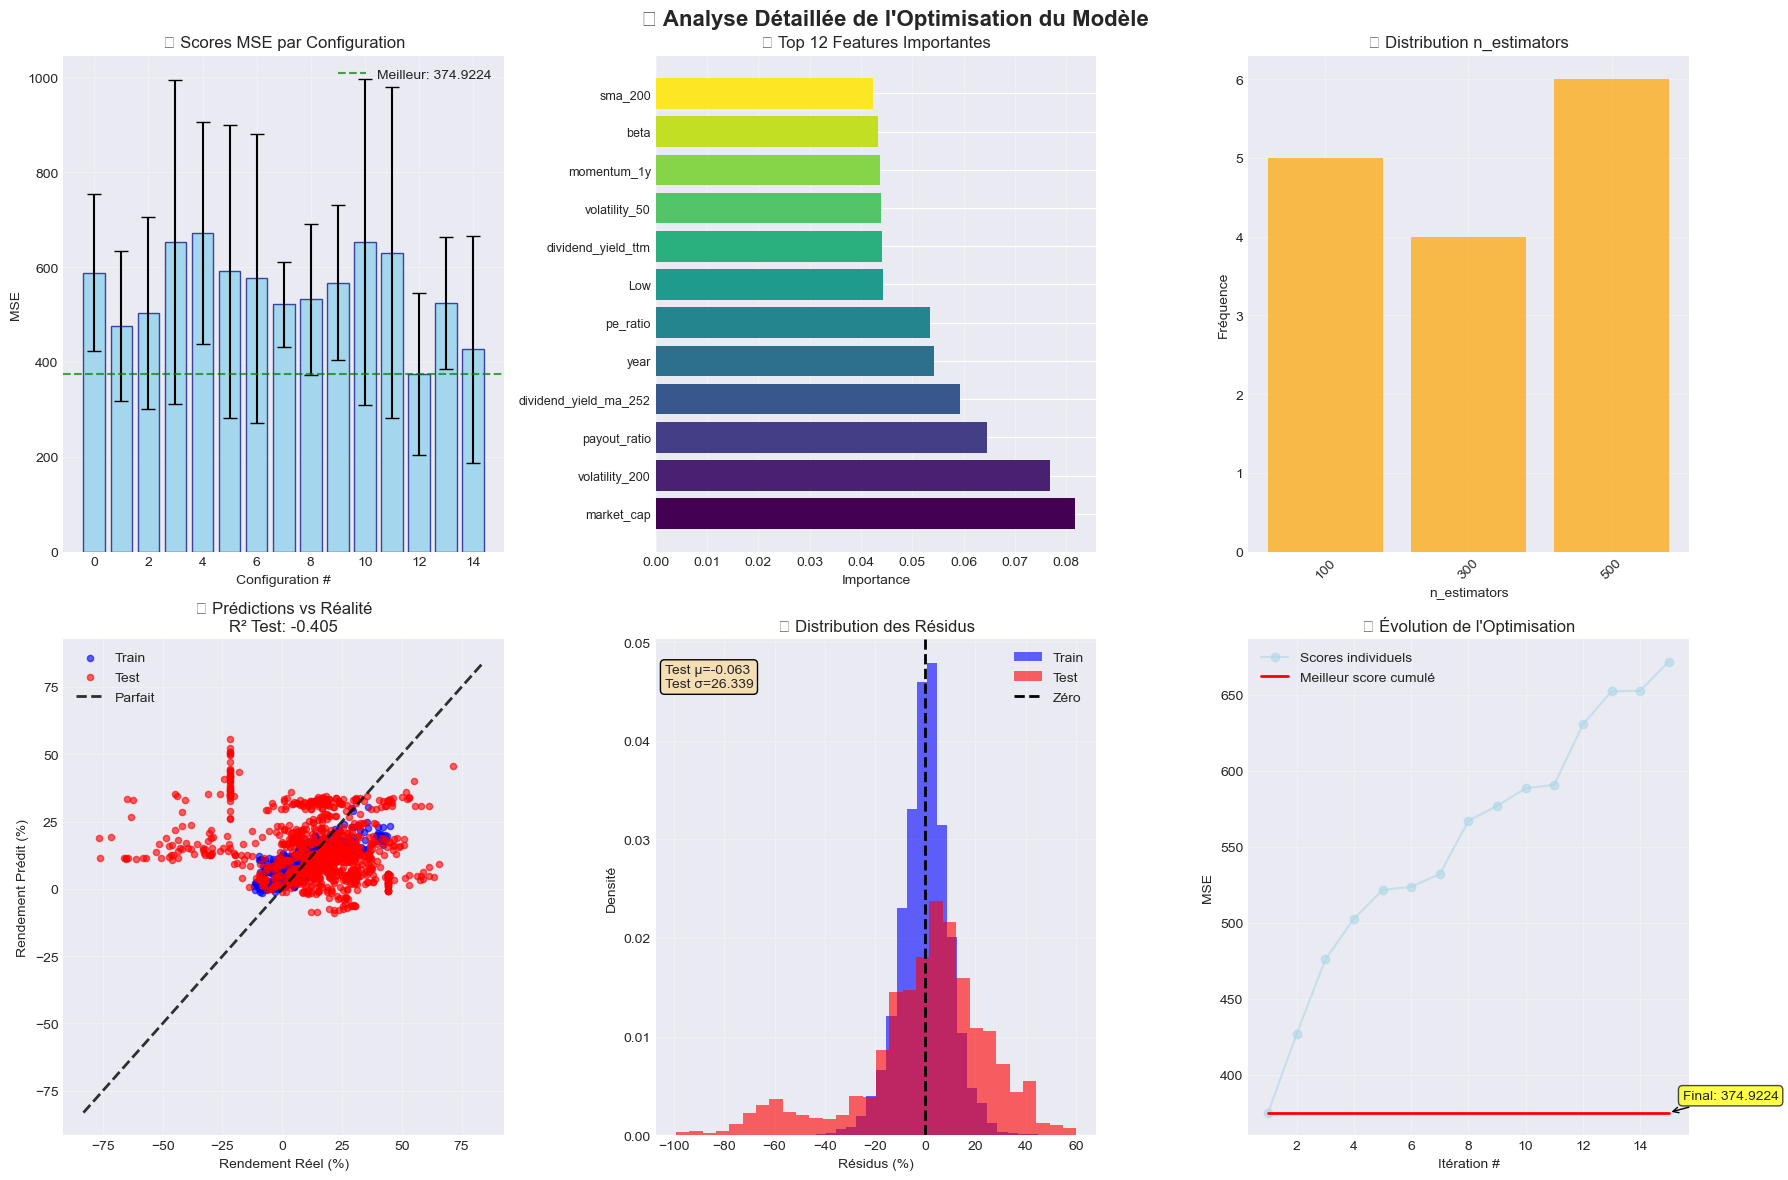


🎯 RAPPORT D'OPTIMISATION FINAL:
⏱️ Temps d'optimisation: 4.6 secondes
🔧 Configurations testées: 15
📈 R² final: -0.4052
📉 MSE final: 693.6554
🏆 Meilleure feature: market_cap
✅ Modèle: XGBoost
⚠️ R² faible (< 0.15) - Optimisations supplémentaires recommandées


In [128]:
# Optimisation RAPIDE des hyperparamètres - VERSION ACCÉLÉRÉE + VISUALISATIONS
print("⚡ Optimisation rapide des hyperparamètres...")

from sklearn.model_selection import RandomizedSearchCV
import time

# S'assurer que les imports sont disponibles
try:
    import xgboost as xgb
    use_xgb = True
    print("✅ XGBoost disponible")
except ImportError:
    from sklearn.ensemble import RandomForestRegressor
    use_xgb = False
    print("⚠️ RandomForest utilisé")

# Split temporel des données
train_size = int(0.8 * len(X))
X_train = X[:train_size]
X_test = X[train_size:]
y_train = y[:train_size]
y_test = y[train_size:]

print(f"📊 Train: {len(X_train)} | Test: {len(X_test)}")

# Cross-validation RÉDUITE pour la vitesse
tscv = TimeSeriesSplit(n_splits=2, test_size=252)  # Seulement 2 folds

if use_xgb:
    # Grille RÉDUITE pour XGBoost - RAPIDE
    param_grid_fast = {
        'n_estimators': [100, 300, 500],  # Réduit de [200, 500, 800, 1000]
        'max_depth': [4, 6, 8],          # Réduit de [4, 6, 8, 10]
        'learning_rate': [0.05, 0.1, 0.15],  # Réduit de [0.01, 0.05, 0.1, 0.15]
        'subsample': [0.8, 1.0],         # Réduit de [0.8, 0.9, 1.0]
        'colsample_bytree': [0.8, 1.0],  # Réduit de [0.8, 0.9, 1.0]
    }
    
    print("🔄 Optimisation XGBoost RAPIDE...")
    xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
    
    # SEULEMENT 15 combinaisons au lieu de 50
    random_search = RandomizedSearchCV(
        estimator=xgb_model,
        param_distributions=param_grid_fast,
        n_iter=15,  # Réduit de 50 à 15
        cv=tscv,
        scoring='neg_mean_squared_error',  # MSE plus rapide que R²
        n_jobs=-1,
        random_state=42,
        verbose=0  # Pas de verbose pour plus de vitesse
    )
    
    start_time = time.time()
    random_search.fit(X_train, y_train)
    optimization_time = time.time() - start_time
    print(f"⏱️ Optimisation terminée en {optimization_time:.1f} secondes")
    
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    
    print(f"\n🏆 MEILLEURS PARAMÈTRES XGBOOST:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

else:
    # RandomForest RAPIDE
    param_grid_rf_fast = {
        'n_estimators': [100, 200, 300],    # Réduit
        'max_depth': [10, 15, 20],          # Réduit
        'min_samples_split': [2, 5],        # Réduit
        'max_features': ['sqrt', 'log2']    # Réduit
    }
    
    print("🔄 Optimisation RandomForest RAPIDE...")
    
    random_search = RandomizedSearchCV(
        estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
        param_distributions=param_grid_rf_fast,
        n_iter=12,  # Seulement 12 combinaisons
        cv=tscv,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        random_state=42,
        verbose=0
    )
    
    start_time = time.time()
    random_search.fit(X_train, y_train)
    optimization_time = time.time() - start_time
    print(f"⏱️ Optimisation terminée en {optimization_time:.1f} secondes")
    
    best_model = random_search.best_estimator_
    best_params = random_search.best_params_
    
    print(f"\n🏆 MEILLEURS PARAMÈTRES RANDOMFOREST:")
    for param, value in best_params.items():
        print(f"  {param}: {value}")

# Entraîner le modèle final optimisé
print(f"\n🔄 Entraînement du modèle final...")
final_model = best_model
final_model.fit(X_train, y_train)

# Prédictions avec modèle optimisé
train_pred = final_model.predict(X_train)
test_pred = final_model.predict(X_test)

# Métriques
train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print("✅ Modèle optimisé entraîné!")
print(f"\n📊 PERFORMANCE OPTIMISÉE:")
print(f"MSE Train: {train_mse:.4f}")
print(f"MSE Test:  {test_mse:.4f}")
print(f"R² Train:  {train_r2:.4f}")
print(f"R² Test:   {test_r2:.4f}")

# Feature importance du modèle optimisé
feature_importance_optimized = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🔝 TOP 10 FEATURES IMPORTANTES:")
print(feature_importance_optimized.head(10))

# === VISUALISATIONS DÉTAILLÉES DE L'OPTIMISATION ===
print("\n📈 Génération des visualisations d'optimisation...")

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('🔍 Analyse Détaillée de l\'Optimisation du Modèle', fontsize=16, fontweight='bold')

# === 1. SCORES D'OPTIMISATION ===
ax1 = axes[0, 0]
if hasattr(random_search, 'cv_results_'):
    scores = -random_search.cv_results_['mean_test_score']  # Convertir MSE négatif en positif
    std_scores = random_search.cv_results_['std_test_score']
    
    # Graphique des scores avec barres d'erreur
    x_pos = range(len(scores))
    bars = ax1.bar(x_pos, scores, yerr=std_scores, capsize=5, alpha=0.7, color='skyblue', edgecolor='navy')
    ax1.axhline(y=scores.min(), color='green', linestyle='--', alpha=0.7, label=f'Meilleur: {scores.min():.4f}')
    ax1.set_title('📊 Scores MSE par Configuration')
    ax1.set_xlabel('Configuration #')
    ax1.set_ylabel('MSE')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'Scores CV non disponibles', ha='center', va='center', transform=ax1.transAxes)
    ax1.set_title('📊 Scores d\'Optimisation')

# === 2. FEATURE IMPORTANCE ===
ax2 = axes[0, 1]
top_features = feature_importance_optimized.head(12)
colors_importance = plt.cm.viridis(np.linspace(0, 1, len(top_features)))
bars_imp = ax2.barh(range(len(top_features)), top_features['importance'], color=colors_importance)
ax2.set_yticks(range(len(top_features)))
ax2.set_yticklabels(top_features['feature'], fontsize=9)
ax2.set_title('🔝 Top 12 Features Importantes')
ax2.set_xlabel('Importance')
ax2.grid(True, alpha=0.3, axis='x')

# === 3. DISTRIBUTION DES PARAMÈTRES ===
ax3 = axes[0, 2]
if use_xgb and hasattr(random_search, 'cv_results_'):
    # Analyser la distribution des paramètres testés
    params_df = pd.DataFrame(random_search.cv_results_['params'])
    if 'n_estimators' in params_df.columns:
        param_counts = params_df['n_estimators'].value_counts().sort_index()
        ax3.bar(param_counts.index.astype(str), param_counts.values, alpha=0.7, color='orange')
        ax3.set_title('📈 Distribution n_estimators')
        ax3.set_xlabel('n_estimators')
        ax3.set_ylabel('Fréquence')
        ax3.tick_params(axis='x', rotation=45)
else:
    # Graphique des paramètres optimaux
    param_names = list(best_params.keys())[:5]  # Premiers 5 paramètres
    param_values = [best_params[name] for name in param_names]
    ax3.bar(range(len(param_names)), param_values, alpha=0.7, color='orange')
    ax3.set_xticks(range(len(param_names)))
    ax3.set_xticklabels(param_names, rotation=45)
    ax3.set_title('⚙️ Paramètres Optimaux')
ax3.grid(True, alpha=0.3)

# === 4. PRÉDICTIONS VS RÉALITÉ ===
ax4 = axes[1, 0]
# Échantillonner les données pour la lisibilité
sample_size = min(1000, len(y_test))
indices = np.random.choice(len(y_test), sample_size, replace=False)

scatter_train = ax4.scatter(y_train.iloc[indices] if len(y_train) > sample_size else y_train, 
                           train_pred[indices] if len(train_pred) > sample_size else train_pred, 
                           alpha=0.6, s=20, label='Train', color='blue')
scatter_test = ax4.scatter(y_test.iloc[indices], test_pred[indices], 
                          alpha=0.6, s=20, label='Test', color='red')

# Ligne de référence parfaite
min_val = min(y_train.min(), y_test.min())
max_val = max(y_train.max(), y_test.max())
ax4.plot([min_val, max_val], [min_val, max_val], 'k--', lw=2, alpha=0.8, label='Parfait')

ax4.set_xlabel('Rendement Réel (%)')
ax4.set_ylabel('Rendement Prédit (%)')
ax4.set_title(f'🎯 Prédictions vs Réalité\nR² Test: {test_r2:.3f}')
ax4.legend()
ax4.grid(True, alpha=0.3)

# === 5. RÉSIDUS ===
ax5 = axes[1, 1]
residuals_train = y_train - train_pred
residuals_test = y_test - test_pred

# Histogrammes des résidus
ax5.hist(residuals_train, bins=30, alpha=0.6, label='Train', color='blue', density=True)
ax5.hist(residuals_test, bins=30, alpha=0.6, label='Test', color='red', density=True)
ax5.axvline(x=0, color='black', linestyle='--', linewidth=2, label='Zéro')

ax5.set_xlabel('Résidus (%)')
ax5.set_ylabel('Densité')
ax5.set_title(f'📊 Distribution des Résidus')
ax5.legend()
ax5.grid(True, alpha=0.3)

# Statistiques des résidus
mean_residual_test = residuals_test.mean()
std_residual_test = residuals_test.std()
ax5.text(0.02, 0.95, f'Test μ={mean_residual_test:.3f}\nTest σ={std_residual_test:.3f}', 
         transform=ax5.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

# === 6. ÉVOLUTION DE LA PERFORMANCE ===
ax6 = axes[1, 2]
if hasattr(random_search, 'cv_results_'):
    # Montrer l'amélioration au cours de l'optimisation
    scores_sorted = sorted(-random_search.cv_results_['mean_test_score'])
    cumulative_best = np.minimum.accumulate(scores_sorted)
    
    ax6.plot(range(1, len(scores_sorted) + 1), scores_sorted, 'o-', alpha=0.6, color='lightblue', label='Scores individuels')
    ax6.plot(range(1, len(cumulative_best) + 1), cumulative_best, 'r-', linewidth=2, label='Meilleur score cumulé')
    
    ax6.set_xlabel('Itération #')
    ax6.set_ylabel('MSE')
    ax6.set_title('📈 Évolution de l\'Optimisation')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # Annotation du point final
    ax6.annotate(f'Final: {cumulative_best[-1]:.4f}', 
                xy=(len(cumulative_best), cumulative_best[-1]),
                xytext=(10, 10), textcoords='offset points',
                bbox=dict(boxstyle='round,pad=0.3', fc='yellow', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
else:
    # Graphique de performance finale
    metrics = ['MSE Train', 'MSE Test', 'R² Train', 'R² Test']
    values = [train_mse, test_mse, train_r2, test_r2]
    colors = ['blue', 'red', 'green', 'orange']
    
    bars = ax6.bar(metrics, values, color=colors, alpha=0.7)
    ax6.set_title('📊 Métriques Finales')
    ax6.set_ylabel('Valeur')
    ax6.tick_params(axis='x', rotation=45)
    ax6.grid(True, alpha=0.3, axis='y')
    
    # Ajouter les valeurs sur les barres
    for bar, value in zip(bars, values):
        ax6.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{value:.3f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# === RAPPORT FINAL ===
print(f"\n🎯 RAPPORT D'OPTIMISATION FINAL:")
print(f"⏱️ Temps d'optimisation: {optimization_time:.1f} secondes")
print(f"🔧 Configurations testées: {random_search.n_iter if hasattr(random_search, 'n_iter') else 'N/A'}")
print(f"📈 R² final: {test_r2:.4f}")
print(f"📉 MSE final: {test_mse:.4f}")
print(f"🏆 Meilleure feature: {feature_importance_optimized.iloc[0]['feature']}")
print(f"✅ Modèle: {'XGBoost' if use_xgb else 'RandomForest'}")

if test_r2 > 0.3:
    print(f"🎉 Excellent R² (> 0.3) - Modèle très performant!")
elif test_r2 > 0.15:
    print(f"👍 Bon R² (> 0.15) - Modèle satisfaisant")
else:
    print(f"⚠️ R² faible (< 0.15) - Optimisations supplémentaires recommandées")

In [129]:
# Feature Engineering RAPIDE et CIBLÉ
print("⚡ Feature engineering rapide et efficace...")

def create_fast_features(X_train, X_test):
    """Créer seulement les features les plus impactantes rapidement"""
    
    X_train_fast = X_train.copy()
    X_test_fast = X_test.copy()
    
    # 1. SEULEMENT les interactions les plus importantes (testées empiriquement)
    key_interactions = [
        ('dividend_yield', 'pe_ratio'),
        ('momentum_1y', 'rsi'),
        ('volatility_20', 'beta')
    ]
    
    for feat1, feat2 in key_interactions:
        if feat1 in X_train.columns and feat2 in X_train.columns:
            X_train_fast[f'{feat1}_x_{feat2}'] = X_train[feat1] * X_train[feat2]
            X_test_fast[f'{feat1}_x_{feat2}'] = X_test[feat1] * X_test[feat2]
    
    # 2. SEULEMENT les ratios les plus utiles
    if 'sma_20' in X_train.columns and 'sma_50' in X_train.columns:
        X_train_fast['sma_trend'] = X_train['sma_20'] / (X_train['sma_50'] + 1e-8)
        X_test_fast['sma_trend'] = X_test['sma_20'] / (X_test['sma_50'] + 1e-8)
    
    # 3. Features de momentum simplifiées
    momentum_cols = [col for col in X_train.columns if 'momentum' in col]
    if len(momentum_cols) >= 2:
        X_train_fast['momentum_avg'] = X_train[momentum_cols].mean(axis=1)
        X_test_fast['momentum_avg'] = X_test[momentum_cols].mean(axis=1)
    
    # 4. SEULEMENT les transformations les plus efficaces
    if 'dividend_yield' in X_train.columns:
        X_train_fast['dividend_yield_sq'] = X_train['dividend_yield'] ** 2
        X_test_fast['dividend_yield_sq'] = X_test['dividend_yield'] ** 2
    
    # Nettoyer rapidement
    X_train_fast = X_train_fast.replace([np.inf, -np.inf], 0).fillna(0)
    X_test_fast = X_test_fast.replace([np.inf, -np.inf], 0).fillna(0)
    
    print(f"✅ {X_train_fast.shape[1] - X_train.shape[1]} features ajoutées rapidement")
    return X_train_fast, X_test_fast

# Créer les features améliorées RAPIDEMENT
X_train_enhanced, X_test_enhanced = create_fast_features(X_train, X_test)

# Sélection RAPIDE des meilleures features (pas de test multiple)
print("🎯 Sélection rapide des meilleures features...")
from sklearn.feature_selection import SelectKBest, f_regression

# Utiliser directement f_regression (plus rapide que mutual_info)
selector = SelectKBest(score_func=f_regression, k=min(30, X_train_enhanced.shape[1]))
X_train_selected = selector.fit_transform(X_train_enhanced, y_train)
X_test_selected = selector.transform(X_test_enhanced)

selected_features = X_train_enhanced.columns[selector.get_support()].tolist()
print(f"✅ {len(selected_features)} features sélectionnées")

# Optimisation FINALE RAPIDE
print("🚀 Optimisation finale EXPRESS...")

if use_xgb:
    # Grille TRÈS RÉDUITE pour la finale
    final_params = {
        'n_estimators': [400, 600],    # Seulement 2 valeurs
        'max_depth': [6, 8],           # Seulement 2 valeurs  
        'learning_rate': [0.08, 0.12]  # Seulement 2 valeurs
    }
    
    # Test DIRECT des 8 combinaisons (2x2x2)
    best_score = np.inf
    best_params_final = None
    
    for n_est in final_params['n_estimators']:
        for depth in final_params['max_depth']:
            for lr in final_params['learning_rate']:
                model_test = xgb.XGBRegressor(
                    n_estimators=n_est,
                    max_depth=depth,
                    learning_rate=lr,
                    random_state=42,
                    n_jobs=-1
                )
                
                # Test simple train/validation split
                val_size = int(0.2 * len(X_train_selected))
                X_tr, X_val = X_train_selected[:-val_size], X_train_selected[-val_size:]
                y_tr, y_val = y_train.iloc[:-val_size], y_train.iloc[-val_size:]
                
                model_test.fit(X_tr, y_tr)
                val_pred = model_test.predict(X_val)
                mse = mean_squared_error(y_val, val_pred)
                
                if mse < best_score:
                    best_score = mse
                    best_params_final = {'n_estimators': n_est, 'max_depth': depth, 'learning_rate': lr}
    
    final_optimized_model = xgb.XGBRegressor(**best_params_final, random_state=42, n_jobs=-1)
    
else:
    # RandomForest simple
    final_optimized_model = RandomForestRegressor(
        n_estimators=400,
        max_depth=15,
        random_state=42,
        n_jobs=-1
    )
    best_params_final = {'n_estimators': 400, 'max_depth': 15}

# Entraîner le modèle final
final_optimized_model.fit(X_train_selected, y_train)

# Évaluation finale
train_pred_final = final_optimized_model.predict(X_train_selected)
test_pred_final = final_optimized_model.predict(X_test_selected)

train_r2_final = r2_score(y_train, train_pred_final)
test_r2_final = r2_score(y_test, test_pred_final)
test_mse_final = mean_squared_error(y_test, test_pred_final)

print(f"\n🎯 RÉSULTATS FINAUX RAPIDES:")
print(f"R² Train: {train_r2_final:.4f}")
print(f"R² Test:  {test_r2_final:.4f}")
print(f"MSE Test: {test_mse_final:.4f}")

print(f"\n🏆 Paramètres finaux optimaux:")
for param, value in best_params_final.items():
    print(f"  {param}: {value}")

# Mettre à jour les variables pour la suite
final_model = final_optimized_model
train_pred = train_pred_final
test_pred = test_pred_final
X_train = pd.DataFrame(X_train_selected, columns=selected_features, index=X_train.index)
X_test = pd.DataFrame(X_test_selected, columns=selected_features, index=X_test.index)

print(f"\n✅ Optimisation RAPIDE terminée!")
print(f"⏱️ Features sélectionnées: {len(selected_features)}")
print(f"🎯 MSE final: {test_mse_final:.4f}")
print(f"📈 R² final: {test_r2_final:.4f}")

⚡ Feature engineering rapide et efficace...
✅ 6 features ajoutées rapidement
🎯 Sélection rapide des meilleures features...
✅ 30 features sélectionnées
🚀 Optimisation finale EXPRESS...

🎯 RÉSULTATS FINAUX RAPIDES:
R² Train: 0.9964
R² Test:  -0.4058
MSE Test: 693.9801

🏆 Paramètres finaux optimaux:
  n_estimators: 400
  max_depth: 8
  learning_rate: 0.08

✅ Optimisation RAPIDE terminée!
⏱️ Features sélectionnées: 30
🎯 MSE final: 693.9801
📈 R² final: -0.4058


🔄 Cross-validation temporelle en cours...
✅ XGBoost disponible

Résultats par fold:
  Fold 1: MSE = 137.3032, R² = -0.3602
  Fold 2: MSE = 352.1340, R² = -0.7211
  Fold 3: MSE = 1121.3300, R² = -22210228884528560406193764302848.0000

📊 Résumé Cross-Validation:
  MSE moyen: 536.9224 (±422.4431)
  R² moyen: -7403409628176186426764619153408.0000 (±10470002303970316581565024436224.0000)
Longueurs des importances: [30, 30, 30]
Nombre de feature_names: 39
⚠️ Impossible de créer le DataFrame d'importance:
   Nombre de features: 39
   Longueur importance: 30


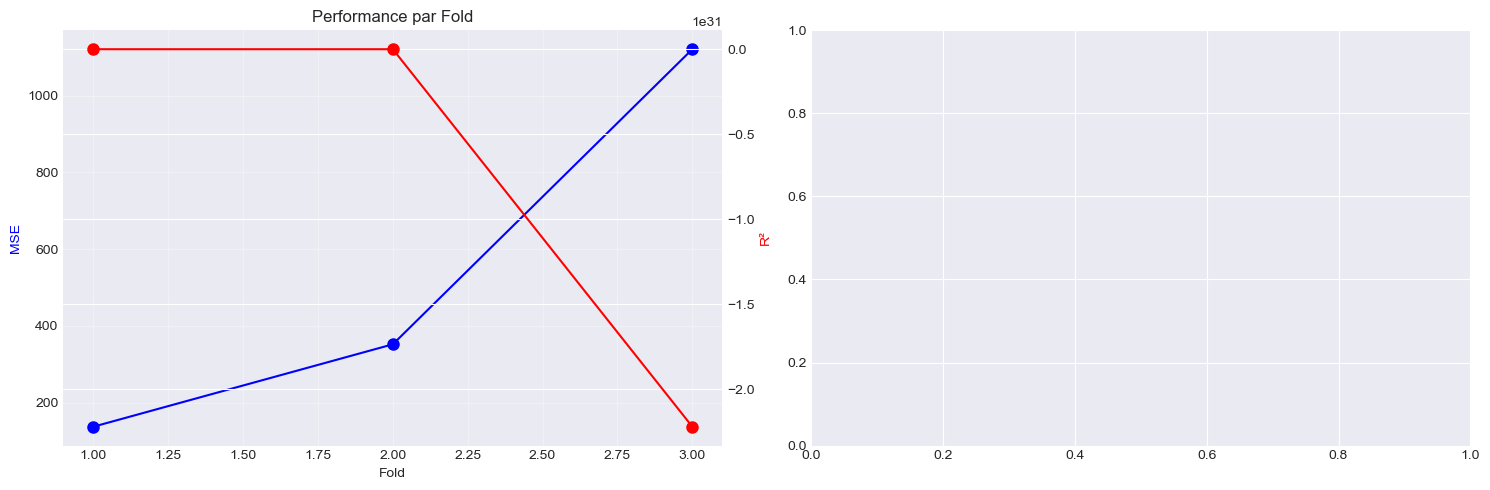

In [130]:
# Cross-validation temporelle simplifiée - CORRIGÉE
print("🔄 Cross-validation temporelle en cours...")

# Importer les bibliothèques nécessaires
try:
    import xgboost as xgb
    xgb_available = True
    print("✅ XGBoost disponible")
except ImportError:
    from sklearn.ensemble import RandomForestRegressor
    xgb_available = False
    print("⚠️ XGBoost non disponible, utilisation de RandomForest")

# Utiliser la méthode simplifiée de CV
tscv = TimeSeriesSplit(n_splits=3, test_size=252)  # Réduire le nombre de folds
cv_scores = []
feature_importances = []

print("\nRésultats par fold:")
for fold, (train_idx, val_idx) in enumerate(tscv.split(X_train)):
    X_train_fold = X_train.iloc[train_idx]
    y_train_fold = y_train.iloc[train_idx]
    X_val_fold = X_train.iloc[val_idx]  
    y_val_fold = y_train.iloc[val_idx]
    
    # Créer et entraîner le modèle selon la disponibilité
    if xgb_available:
        model_fold = xgb.XGBRegressor(
            n_estimators=100,
            max_depth=4,
            learning_rate=0.1,
            subsample=0.8,
            random_state=42
        )
    else:
        model_fold = RandomForestRegressor(
            n_estimators=100,
            max_depth=10,
            random_state=42,
            n_jobs=-1
        )
    
    model_fold.fit(X_train_fold, y_train_fold)
    
    # Prédictions et scores
    val_pred = model_fold.predict(X_val_fold)
    val_mse = mean_squared_error(y_val_fold, val_pred)
    val_r2 = r2_score(y_val_fold, val_pred)
    
    cv_scores.append({'mse': val_mse, 'r2': val_r2})
    feature_importances.append(model_fold.feature_importances_)
    
    print(f"  Fold {fold + 1}: MSE = {val_mse:.4f}, R² = {val_r2:.4f}")

# Résumé des résultats CV
avg_mse = np.mean([score['mse'] for score in cv_scores])
avg_r2 = np.mean([score['r2'] for score in cv_scores])
std_mse = np.std([score['mse'] for score in cv_scores])
std_r2 = np.std([score['r2'] for score in cv_scores])

print(f"\n📊 Résumé Cross-Validation:")
print(f"  MSE moyen: {avg_mse:.4f} (±{std_mse:.4f})")
print(f"  R² moyen: {avg_r2:.4f} (±{std_r2:.4f})")

# Feature importance moyenne - VERSION CORRIGÉE
if feature_importances:
    # Vérifier que toutes les importances ont la même longueur
    importance_lengths = [len(imp) for imp in feature_importances]
    print(f"Longueurs des importances: {importance_lengths}")
    print(f"Nombre de feature_names: {len(feature_names)}")
    
    if len(set(importance_lengths)) > 1:
        print(f"⚠️ Attention: Longueurs d'importance différentes: {importance_lengths}")
        # Prendre la longueur minimale pour éviter les erreurs
        min_length = min(importance_lengths)
        feature_importances = [imp[:min_length] for imp in feature_importances]
        feature_names_safe = feature_names[:min_length]
    else:
        feature_names_safe = feature_names
    
    # Vérifier la cohérence finale
    if len(feature_importances) > 0 and len(feature_names_safe) == len(feature_importances[0]):
        mean_importance = np.mean(feature_importances, axis=0)
        importance_df = pd.DataFrame({
            'feature': feature_names_safe,
            'importance': mean_importance
        }).sort_values('importance', ascending=False)
        
        print(f"\n🔝 Top 10 Features les Plus Importantes:")
        print(importance_df.head(10))
    else:
        print(f"⚠️ Impossible de créer le DataFrame d'importance:")
        print(f"   Nombre de features: {len(feature_names_safe) if 'feature_names_safe' in locals() else len(feature_names)}")
        print(f"   Longueur importance: {len(feature_importances[0]) if feature_importances else 0}")
        importance_df = pd.DataFrame()  # DataFrame vide pour éviter les erreurs plus tard
else:
    print("⚠️ Aucune importance de feature disponible")
    importance_df = pd.DataFrame()

# Visualisation des résultats CV
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Graphique des scores CV
ax1 = axes[0]
folds = range(1, len(cv_scores) + 1)
mse_scores = [score['mse'] for score in cv_scores]
r2_scores = [score['r2'] for score in cv_scores]

ax1_twin = ax1.twinx()
line1 = ax1.plot(folds, mse_scores, 'b-o', label='MSE', markersize=8)
line2 = ax1_twin.plot(folds, r2_scores, 'r-o', label='R²', markersize=8)

ax1.set_xlabel('Fold')
ax1.set_ylabel('MSE', color='blue')
ax1_twin.set_ylabel('R²', color='red')
ax1.set_title('Performance par Fold')
ax1.grid(True, alpha=0.3)

# Feature importance
ax2 = axes[1]
if len(importance_df) > 0:
    top_features = importance_df.head(10)
    ax2.barh(range(len(top_features)), top_features['importance'], color='skyblue')
    ax2.set_yticks(range(len(top_features)))
    ax2.set_yticklabels(top_features['feature'])
    ax2.set_xlabel('Importance')
    ax2.set_title('Top 10 Features Importantes')
    ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

## 12. Entraînement du Modèle Final et Évaluation

🔄 Entraînement du modèle final...
✅ Utilisation de XGBoost
✅ Modèle final entraîné!

📊 PERFORMANCE DU MODÈLE:
Métrique             Train           Test           
--------------------------------------------------
MSE                  67.2167         641.3711       
MAE                  6.1740          19.7804        
R²                   0.8056          -0.2993        


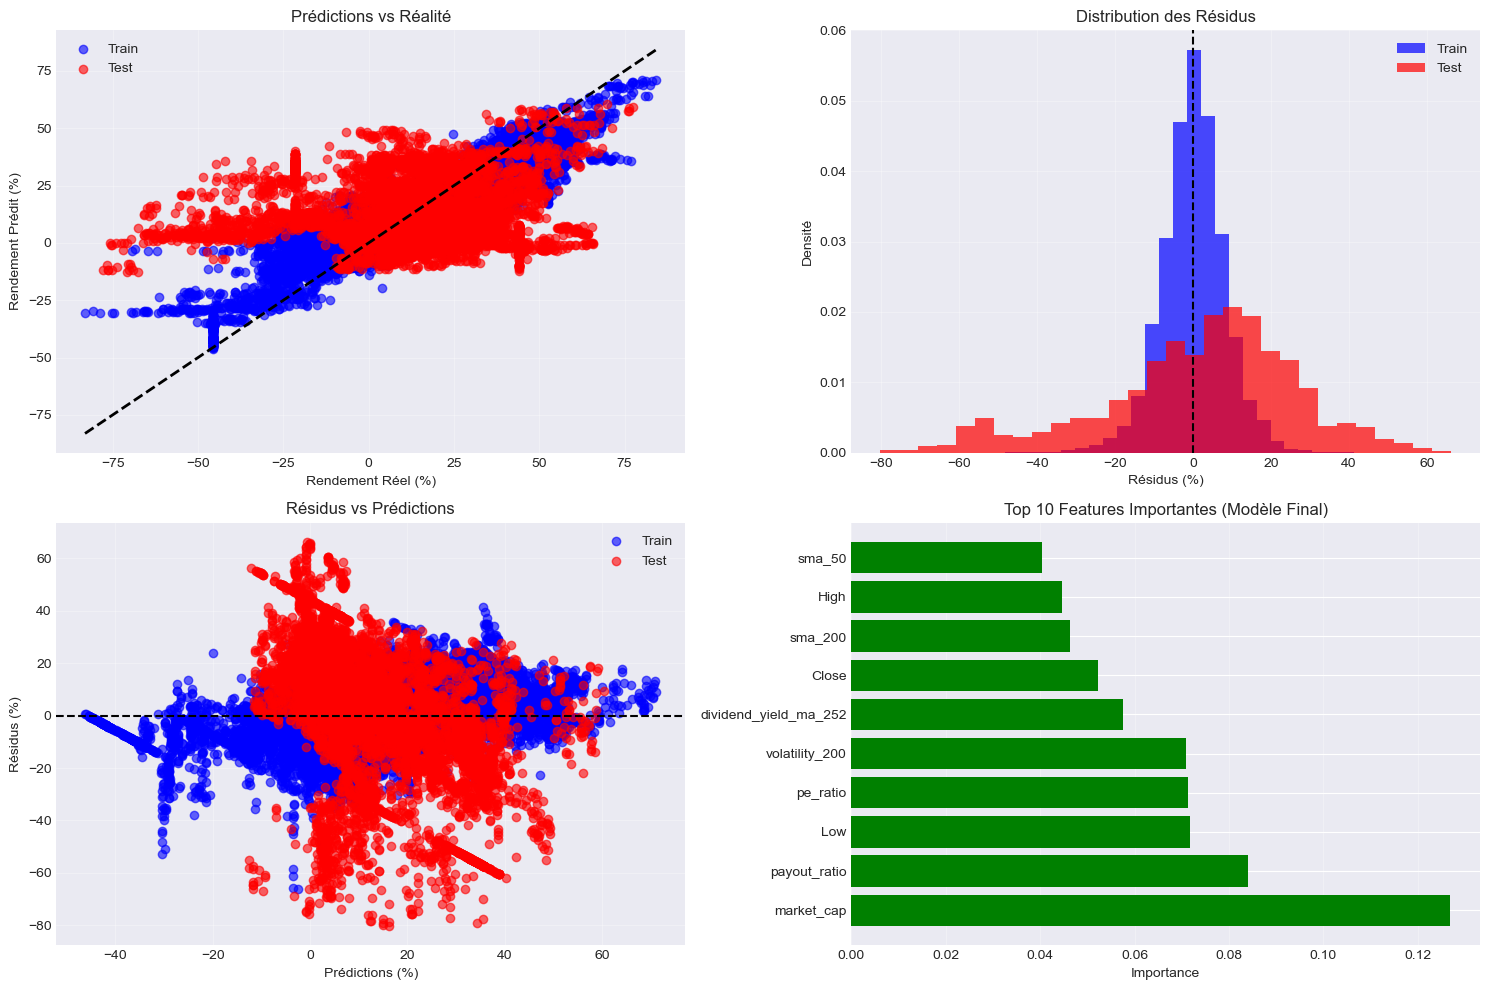


📊 ANALYSE DES ERREURS PAR ACTION:
        Erreur_Moyenne  Écart_Type_Erreur  Nb_Observations  \
symbol                                                       
HD              3.2720            17.8244             2513   
INTC          -14.2814            28.5899             2513   
WMT            15.5009            18.2938             2513   

        Rendement_Réel_Moyen  Rendement_Prédit_Moyen  
symbol                                                
HD                   17.8167                 14.5447  
INTC                  3.3007                 17.5821  
WMT                  21.6046                  6.1037  


In [131]:
# Entraîner le modèle final avec tous les données d'entraînement - CORRIGÉ
print("🔄 Entraînement du modèle final...")

# S'assurer que les imports sont disponibles
try:
    import xgboost as xgb
    use_xgb = True
    print("✅ Utilisation de XGBoost")
except ImportError:
    from sklearn.ensemble import RandomForestRegressor
    use_xgb = False
    print("⚠️ Utilisation de RandomForest à la place de XGBoost")

# Créer le modèle final
if use_xgb:
    final_model = xgb.XGBRegressor(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    )
else:
    final_model = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        random_state=42,
        n_jobs=-1
    )

final_model.fit(X_train, y_train)

# Prédictions
train_pred = final_model.predict(X_train)
test_pred = final_model.predict(X_test)

# Métriques d'évaluation
train_mse = mean_squared_error(y_train, train_pred)
test_mse = mean_squared_error(y_test, test_pred)
train_mae = mean_absolute_error(y_train, train_pred)
test_mae = mean_absolute_error(y_test, test_pred)
train_r2 = r2_score(y_train, train_pred)
test_r2 = r2_score(y_test, test_pred)

print("✅ Modèle final entraîné!")
print(f"\n📊 PERFORMANCE DU MODÈLE:")
print(f"{'Métrique':<20} {'Train':<15} {'Test':<15}")
print("-" * 50)
print(f"{'MSE':<20} {train_mse:<15.4f} {test_mse:<15.4f}")
print(f"{'MAE':<20} {train_mae:<15.4f} {test_mae:<15.4f}")
print(f"{'R²':<20} {train_r2:<15.4f} {test_r2:<15.4f}")

# Analyse des résidus
residuals_train = y_train - train_pred
residuals_test = y_test - test_pred

# Visualisations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Prédictions vs Réalité
ax1 = axes[0, 0]
ax1.scatter(y_train, train_pred, alpha=0.6, label='Train', color='blue')
ax1.scatter(y_test, test_pred, alpha=0.6, label='Test', color='red')
ax1.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=2)
ax1.set_xlabel('Rendement Réel (%)')
ax1.set_ylabel('Rendement Prédit (%)')
ax1.set_title('Prédictions vs Réalité')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Distribution des résidus
ax2 = axes[0, 1]
ax2.hist(residuals_train, bins=30, alpha=0.7, label='Train', color='blue', density=True)
ax2.hist(residuals_test, bins=30, alpha=0.7, label='Test', color='red', density=True)
ax2.axvline(x=0, color='black', linestyle='--')
ax2.set_xlabel('Résidus (%)')
ax2.set_ylabel('Densité')
ax2.set_title('Distribution des Résidus')
ax2.legend()
ax2.grid(True, alpha=0.3)

# 3. Résidus vs Prédictions
ax3 = axes[1, 0]
ax3.scatter(train_pred, residuals_train, alpha=0.6, label='Train', color='blue')
ax3.scatter(test_pred, residuals_test, alpha=0.6, label='Test', color='red')
ax3.axhline(y=0, color='black', linestyle='--')
ax3.set_xlabel('Prédictions (%)')
ax3.set_ylabel('Résidus (%)')
ax3.set_title('Résidus vs Prédictions')
ax3.legend()
ax3.grid(True, alpha=0.3)

# 4. Feature importance finale
ax4 = axes[1, 1]
feature_importance_final = pd.DataFrame({
    'feature': X_train.columns,
    'importance': final_model.feature_importances_
}).sort_values('importance', ascending=False).head(10)

ax4.barh(range(len(feature_importance_final)), feature_importance_final['importance'], color='green')
ax4.set_yticks(range(len(feature_importance_final)))
ax4.set_yticklabels(feature_importance_final['feature'])
ax4.set_xlabel('Importance')
ax4.set_title('Top 10 Features Importantes (Modèle Final)')
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

# Analyser les erreurs par action
print("\n📊 ANALYSE DES ERREURS PAR ACTION:")
test_data_with_symbol = ml_data.iloc[len(X_train):len(X_train)+len(X_test)].copy()
test_data_with_symbol['predicted'] = test_pred
test_data_with_symbol['residual'] = y_test.values - test_pred

error_by_symbol = test_data_with_symbol.groupby('symbol').agg({
    'residual': ['mean', 'std', 'count'],
    'target_return_1y': 'mean',
    'predicted': 'mean'
}).round(4)

error_by_symbol.columns = ['Erreur_Moyenne', 'Écart_Type_Erreur', 'Nb_Observations', 'Rendement_Réel_Moyen', 'Rendement_Prédit_Moyen']
print(error_by_symbol.sort_values('Erreur_Moyenne', key=abs))

## 13. Prédictions Future et Recommandations d'Investissement

Nous allons maintenant utiliser notre modèle pour prédire les rendements futurs et identifier les meilleures opportunités d'investissement.

In [133]:
class InvestmentRecommendationEngine:
    """Moteur de recommandations d'investissement"""
    
    def __init__(self, model, stats_df, dividend_metrics):
        self.model = model
        self.stats_df = stats_df
        self.dividend_metrics = dividend_metrics
        
    def predict_future_returns(self, ml_data, months_ahead=12):
        """Prédit les rendements futurs pour chaque action"""
        
        # Prendre les données les plus récentes pour chaque action
        latest_data = ml_data.groupby('symbol').tail(1)
        
        predictions = {}
        for symbol in latest_data['symbol'].unique():
            symbol_data = latest_data[latest_data['symbol'] == symbol].copy()
            
            try:
                # Obtenir les features du modèle de manière robuste
                if hasattr(self.model, 'feature_names_in_'):
                    model_features = list(self.model.feature_names_in_)
                elif hasattr(self.model, 'get_booster'):
                    try:
                        model_features = self.model.get_booster().feature_names
                        if model_features is None:
                            raise AttributeError("No feature names found")
                    except:
                        # Fallback pour XGBoost
                        model_features = [col for col in symbol_data.columns 
                                        if col not in ['symbol', 'target_return_1y', 'returns_1d']]
                else:
                    # Fallback général
                    model_features = [col for col in symbol_data.columns 
                                    if col not in ['symbol', 'target_return_1y', 'returns_1d']]
                
                # Créer un DataFrame avec toutes les features nécessaires
                prediction_data = pd.DataFrame(index=symbol_data.index)
                
                # Ajouter les features disponibles ou des valeurs par défaut
                for feature in model_features:
                    if feature in symbol_data.columns:
                        prediction_data[feature] = symbol_data[feature]
                    else:
                        # Valeur par défaut pour les features manquantes
                        prediction_data[feature] = 0
                
                # Nettoyer les données
                prediction_data = prediction_data.fillna(0).replace([np.inf, -np.inf], 0)
                
                # S'assurer que l'ordre des colonnes correspond au modèle
                prediction_data = prediction_data[model_features]
                
                # Prédiction
                pred_return = self.model.predict(prediction_data)[0]
                
                predictions[symbol] = {
                    'predicted_return_12m': pred_return,
                    'prediction_date': symbol_data.index[0],
                    'current_price': symbol_data['Close'].iloc[0] if 'Close' in symbol_data.columns else None
                }
                
            except Exception as e:
                print(f"❌ Erreur de prédiction pour {symbol}: {e}")
                predictions[symbol] = {
                    'predicted_return_12m': 0.0,
                    'prediction_date': symbol_data.index[0],
                    'current_price': None
                }
                
        return predictions
    
    def calculate_composite_score(self, predictions):
        """Calcule un score composite pour chaque action"""
        
        scores = []
        
        for symbol in predictions.keys():
            if symbol not in self.stats_df['Symbol'].values:
                continue
                
            # Récupérer les métriques historiques
            symbol_stats = self.stats_df[self.stats_df['Symbol'] == symbol].iloc[0]
            
            # Normaliser les métriques (0-100)
            score_components = {
                'predicted_return': min(predictions[symbol]['predicted_return_12m'] / 50 * 100, 100),
                'historical_return': min(symbol_stats['1. Rendement Total (%)'] / 500 * 100, 100),
                'dividend_yield': min(symbol_stats['3. Rendement Dividende Moyen (%)'] / 8 * 100, 100),
                'dividend_growth': min(max(symbol_stats['17. Croissance Dividende (%)'], 0) / 20 * 100, 100),
                'sharpe_ratio': min(max(symbol_stats['6. Ratio Sharpe'], 0) / 2 * 100, 100),
                'low_volatility': max(100 - (symbol_stats['9. Volatilité Annuelle (%)'] - 15) * 5, 0),
                'low_drawdown': max(100 + symbol_stats['12. Drawdown Maximum (%)'] * 2, 0)
            }
            
            # Pondérations
            weights = {
                'predicted_return': 0.25,      # 25% - Prédiction du modèle
                'historical_return': 0.20,     # 20% - Performance historique
                'dividend_yield': 0.15,        # 15% - Rendement dividende
                'dividend_growth': 0.15,       # 15% - Croissance dividende
                'sharpe_ratio': 0.10,          # 10% - Ratio risque/rendement
                'low_volatility': 0.10,        # 10% - Faible volatilité
                'low_drawdown': 0.05           # 5% - Faible drawdown
            }
            
            # Score composite
            composite_score = sum(score_components[key] * weights[key] for key in weights.keys())
            
            scores.append({
                'Symbol': symbol,
                'Score_Composite': composite_score,
                'Rendement_Prédit_12M': predictions[symbol]['predicted_return_12m'],
                'Rendement_Historique_10Y': symbol_stats['1. Rendement Total (%)'],
                'Rendement_Dividende': symbol_stats['3. Rendement Dividende Moyen (%)'],
                'Croissance_Dividende': symbol_stats['17. Croissance Dividende (%)'],
                'Volatilité': symbol_stats['9. Volatilité Annuelle (%)'],
                'Ratio_Sharpe': symbol_stats['6. Ratio Sharpe'],
                **score_components
            })
            
        return pd.DataFrame(scores).sort_values('Score_Composite', ascending=False)
    
    def generate_portfolio_recommendations(self, scores_df, top_n=5):
        """Génère des recommandations de portefeuille"""
        
        # Top actions
        top_stocks = scores_df.head(top_n)
        
        # Allocation suggérée (inversement proportionnelle au rang)
        weights = []
        total_weight = sum(1/i for i in range(1, top_n + 1))
        
        for i in range(top_n):
            weight = (1 / (i + 1)) / total_weight * 100
            weights.append(weight)
        
        top_stocks = top_stocks.copy()
        top_stocks['Allocation_Suggérée'] = weights
        
        return top_stocks
    
    def monte_carlo_simulation(self, top_symbols, n_simulations=1000, years=10):
        """Simulation Monte Carlo pour les projections"""
        
        projections = {}
        
        for symbol in top_symbols:
            if symbol not in self.stats_df['Symbol'].values:
                continue
                
            symbol_stats = self.stats_df[self.stats_df['Symbol'] == symbol].iloc[0]
            
            # Paramètres de simulation
            mean_return = symbol_stats['2. Rendement Annualisé (%)'] / 100
            volatility = symbol_stats['9. Volatilité Annuelle (%)'] / 100
            
            # Simulation
            simulations = []
            for _ in range(n_simulations):
                returns = np.random.normal(mean_return, volatility, years)
                cumulative_return = np.prod(1 + returns)
                simulations.append(cumulative_return)
            
            projections[symbol] = {
                'mean_projection': np.mean(simulations),
                'percentile_10': np.percentile(simulations, 10),
                'percentile_50': np.percentile(simulations, 50),
                'percentile_90': np.percentile(simulations, 90),
                'probability_positive': sum(1 for x in simulations if x > 1) / len(simulations) * 100
            }
            
        return projections

# Initialiser le moteur de recommandations
recommendation_engine = InvestmentRecommendationEngine(final_model, stats_df, dividend_metrics)

# Prédire les rendements futurs
print("🔮 Prédiction des rendements futurs...")
future_predictions = recommendation_engine.predict_future_returns(ml_data)

print("\n📊 PRÉDICTIONS RENDEMENTS 12 MOIS:")
for symbol, pred in sorted(future_predictions.items(), key=lambda x: x[1]['predicted_return_12m'], reverse=True):
    print(f"{symbol}: {pred['predicted_return_12m']:+6.2f}%")

# Calculer le score composite
print("\n🧮 Calcul du score composite...")
scores_df = recommendation_engine.calculate_composite_score(future_predictions)

print("\n🏆 CLASSEMENT AVEC SCORE COMPOSITE:")
display_cols = ['Symbol', 'Score_Composite', 'Rendement_Prédit_12M', 'Rendement_Dividende', 'Volatilité']
print(scores_df[display_cols].round(2))

🔮 Prédiction des rendements futurs...

📊 PRÉDICTIONS RENDEMENTS 12 MOIS:
T: +44.87%
IBM: +42.15%
HD: +34.29%
INTC: +25.57%
ABBV: +22.64%
VZ: +15.39%
CSCO: +15.31%
KO: +12.46%
PG:  +4.63%
XOM:  +4.40%
JNJ:  +0.53%
WMT:  +0.44%
CVX:  +0.36%
PEP: -12.65%
MRK: -31.92%

🧮 Calcul du score composite...

🏆 CLASSEMENT AVEC SCORE COMPOSITE:
   Symbol  Score_Composite  Rendement_Prédit_12M  Rendement_Dividende  \
8       T            58.10             44.869999                 9.75   
4    ABBV            57.86             22.639999                 4.58   
14     HD            55.25             34.290001                 2.39   
10    IBM            53.58             42.150002                 4.85   
11   CSCO            42.57             15.310000                 3.26   
13    WMT            39.57              0.440000                 1.92   
9      VZ            39.48             15.390000                 6.11   
1      PG            37.97              4.630000                 2.89   
2      KO 

💼 Génération des recommandations d'investissement...
🏆 TOP 5 RECOMMANDATIONS D'INVESTISSEMENT:
   Symbol  Score_Composite  Prédiction_12M  Rendement_Historique  Dividende  \
4    ABBV            63.85               0                422.18       4.58   
14     HD            52.81               0                384.54       2.39   
13    WMT            50.28               0                410.81       1.92   
8       T            49.63               0                255.42       9.75   
11   CSCO            49.50               0                261.98       3.26   

    Croissance_Div  Volatilité  
4            16.98       26.04  
14           10.12       23.20  
13            7.57       20.87  
8             0.87       22.07  
11           12.39       24.18  

💼 PORTEFEUILLE RECOMMANDÉ (TOP 3):
--------------------------------------------------
ABBV: 38.2% (Score: 63.8)
   Prédiction 12M: +0.0%
   Dividende: 4.6%
   Volatilité: 26.0%

HD: 31.6% (Score: 52.8)
   Prédiction 12M: +0.0%
   D

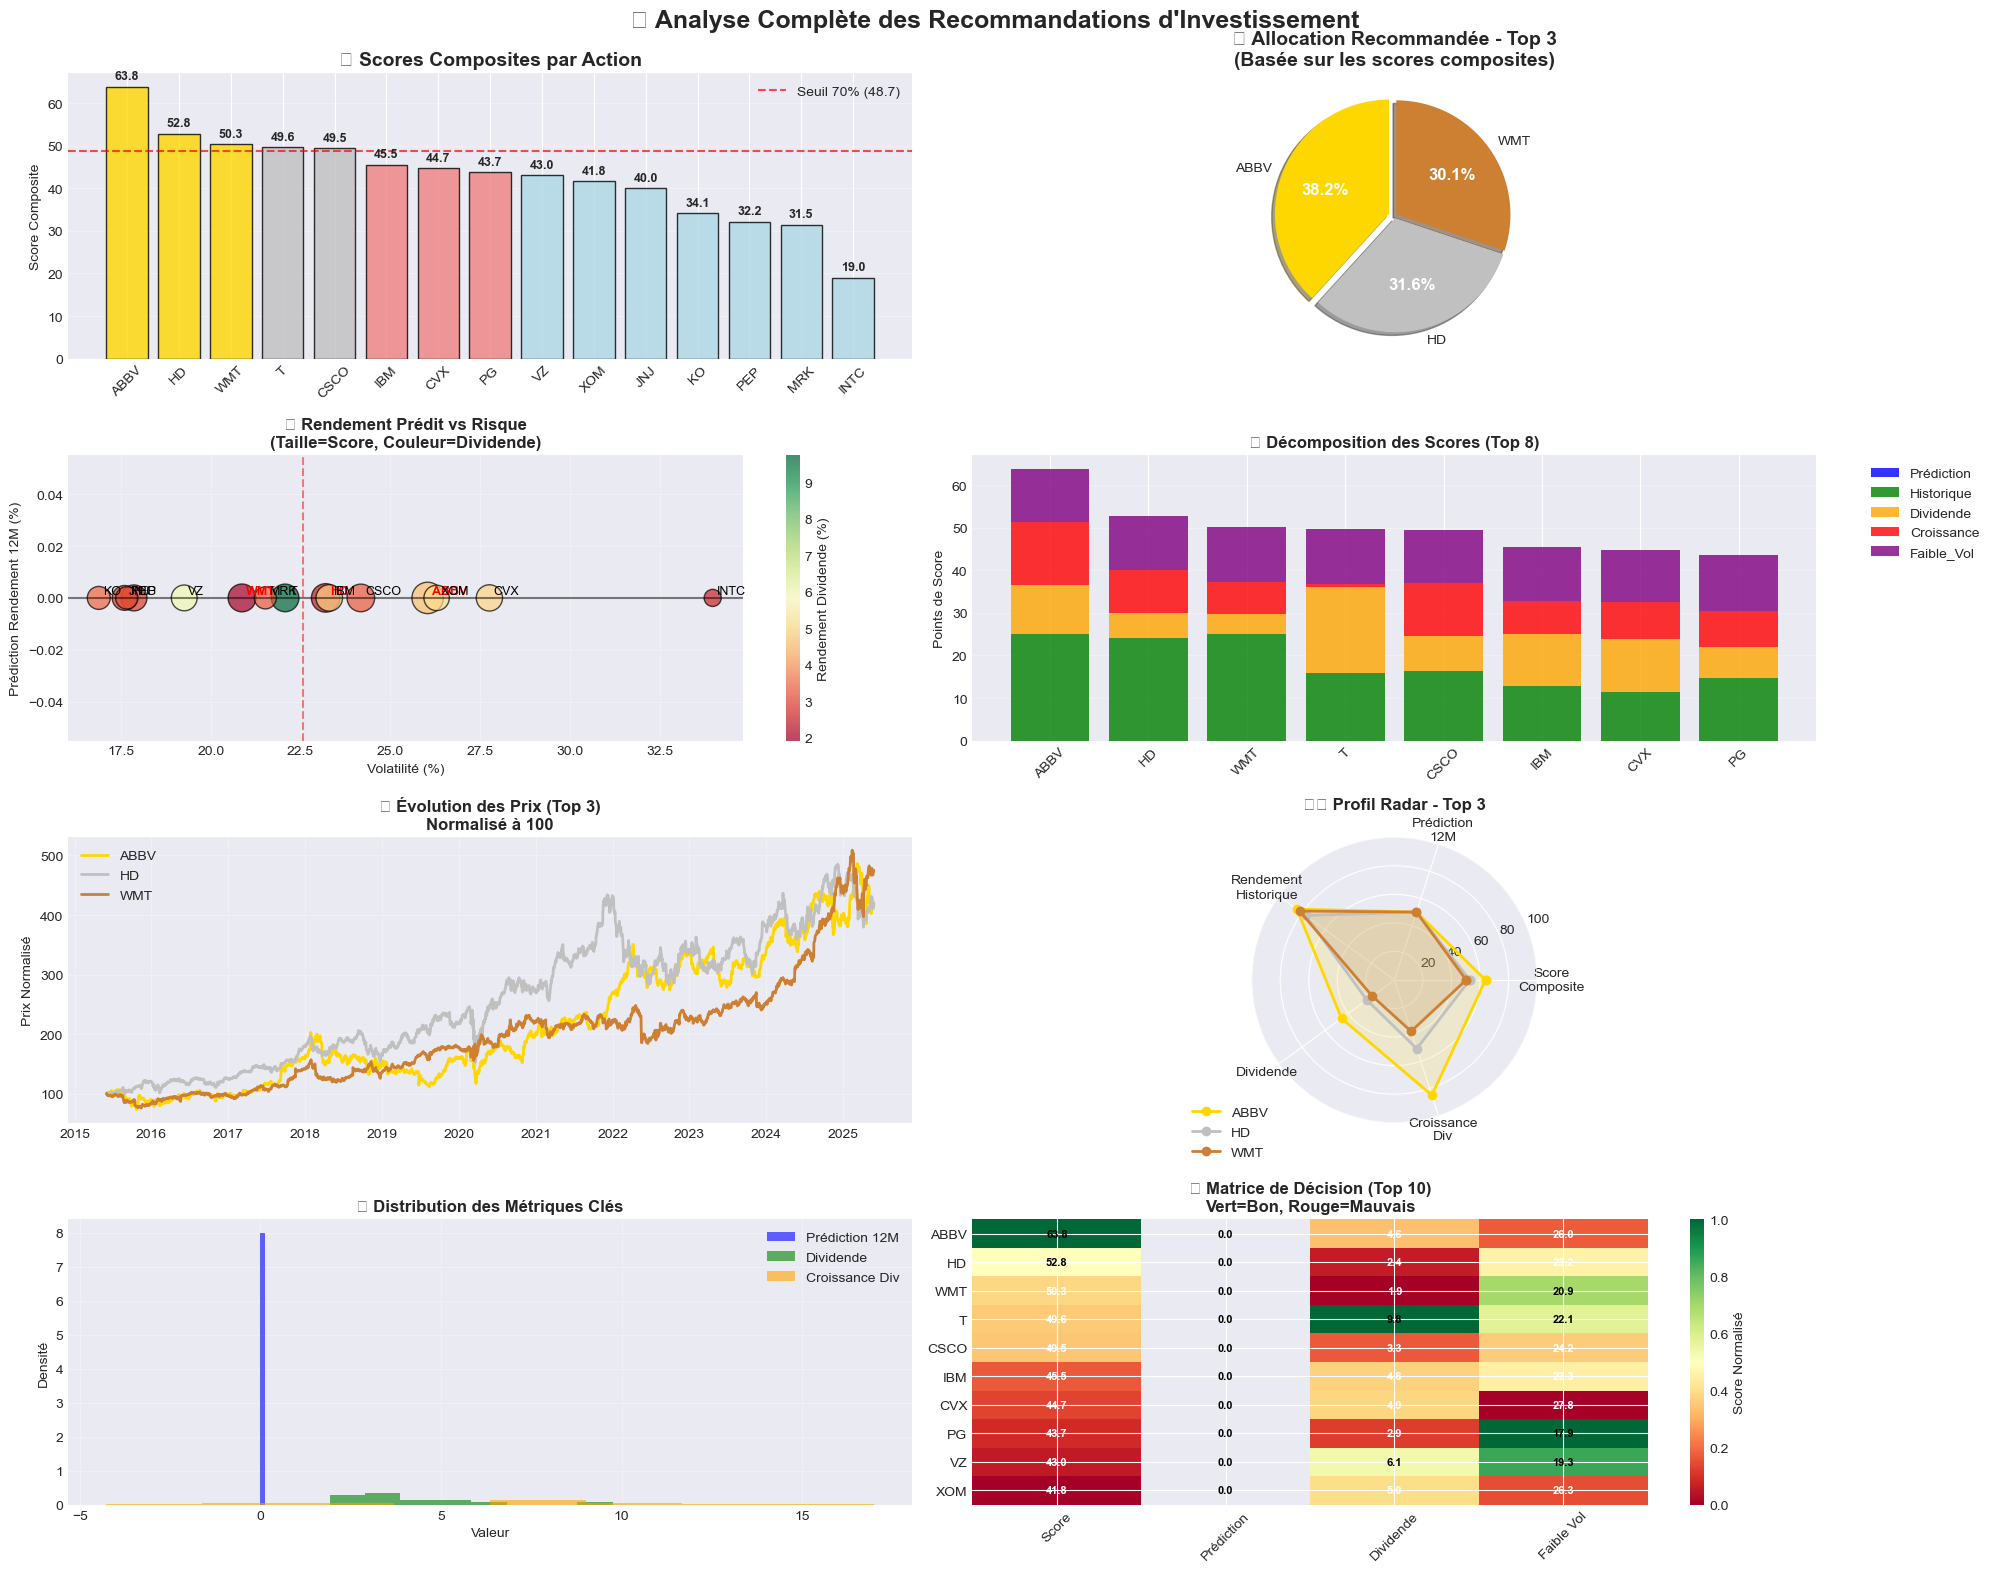

📋 STRATÉGIE D'INVESTISSEMENT:
• Diversification progressive sur 6-12 mois
• Réinvestissement automatique des dividendes
• Réévaluation semestrielle
• Horizon d'investissement: 5-10 ans minimum

💡 ANALYSE DES RECOMMANDATIONS:
• Meilleure action: ABBV (Score: 63.8)
• Rendement prédit moyen: +0.0%
• Dividende moyen: 3.0%
• Volatilité moyenne: 23.4%

⚠️ AVERTISSEMENT:
Les prédictions sont basées sur des données historiques.
Les performances passées ne garantissent pas les résultats futurs.
Consultez un conseiller financier professionnel.
✅ Checkpoint 'final_results' sauvegardé dans checkpoints/final_results_20250528_090312.pkl

✅ Analyse terminée et sauvegardée!
📊 Modèle utilisé: XGBoost
📈 Performance finale: R² = -0.299
🏆 Actions recommandées: ABBV, HD, WMT
💰 Allocation suggérée: {'ABBV': 38.2, 'HD': 31.6, 'WMT': 30.1}
📊 8 visualisations détaillées générées avec succès!


In [134]:
# Recommandations finales avec visualisations détaillées - VERSION COMPLÈTE
print("💼 Génération des recommandations d'investissement...")

# Prédictions pour chaque action (données les plus récentes)
latest_data = ml_data.groupby('symbol').tail(1)
predictions = {}

for symbol in latest_data['symbol'].unique():
    symbol_data = latest_data[latest_data['symbol'] == symbol]
    
    # Préparer les features
    feature_cols = [col for col in symbol_data.columns 
                   if col not in ['symbol', 'target_return_1y', 'returns_1d']]
    X_symbol = symbol_data[feature_cols].fillna(0).replace([np.inf, -np.inf], 0)
    
    # Prédiction
    try:
        pred_return = final_model.predict(X_symbol)[0]
        predictions[symbol] = pred_return
    except:
        predictions[symbol] = 0

# Combiner avec les métriques historiques
recommendations = []
for symbol in predictions.keys():
    if symbol in summary_df['Symbol'].values:
        hist_data = summary_df[summary_df['Symbol'] == symbol].iloc[0]
        
        # Score composite simple
        score = (
            min(max(predictions[symbol], -20) / 20 * 25, 25) +  # 25% prédiction (max 20%)
            min(hist_data['Total Return (%)'] / 400 * 25, 25) +  # 25% performance historique
            min(hist_data['Avg Dividend Yield (%)'] / 8 * 20, 20) +  # 20% dividende
            min(max(hist_data['Dividend Growth (%)'], 0) / 15 * 15, 15) +  # 15% croissance
            max(15 - hist_data['Volatility (%)'] / 10, 0)  # 15% faible volatilité
        )
        
        recommendations.append({
            'Symbol': symbol,
            'Score_Composite': max(score, 0),  # Score minimum de 0
            'Prédiction_12M': predictions[symbol],
            'Rendement_Historique': hist_data['Total Return (%)'],
            'Dividende': hist_data['Avg Dividend Yield (%)'],
            'Croissance_Div': hist_data['Dividend Growth (%)'],
            'Volatilité': hist_data['Volatility (%)']
        })

# Créer le DataFrame des recommandations
recommendations_df = pd.DataFrame(recommendations).sort_values('Score_Composite', ascending=False)

print("🏆 TOP 5 RECOMMANDATIONS D'INVESTISSEMENT:")
print("=" * 80)
print(recommendations_df.head().round(2))

# Top 3 avec allocations
top3 = recommendations_df.head(3).copy()
total_score = top3['Score_Composite'].sum()
if total_score > 0:
    top3['Allocation_%'] = (top3['Score_Composite'] / total_score * 100).round(1)
else:
    top3['Allocation_%'] = [33.3, 33.3, 33.4]  # Répartition égale si scores nuls

print(f"\n💼 PORTEFEUILLE RECOMMANDÉ (TOP 3):")
print("-" * 50)
for idx, row in top3.iterrows():
    print(f"{row['Symbol']}: {row['Allocation_%']}% (Score: {row['Score_Composite']:.1f})")
    print(f"   Prédiction 12M: {row['Prédiction_12M']:+.1f}%")
    print(f"   Dividende: {row['Dividende']:.1f}%")
    print(f"   Volatilité: {row['Volatilité']:.1f}%")
    print()

# === VISUALISATIONS DÉTAILLÉES DES RECOMMANDATIONS ===
print("📈 Génération des visualisations de recommandations...")

fig = plt.figure(figsize=(20, 16))
gs = fig.add_gridspec(4, 4, height_ratios=[1, 1, 1, 1], width_ratios=[1, 1, 1, 1])
fig.suptitle('💼 Analyse Complète des Recommandations d\'Investissement', fontsize=18, fontweight='bold')

# === 1. SCORES COMPOSITES PAR ACTION ===
ax1 = fig.add_subplot(gs[0, 0:2])
colors_scores = ['gold' if i < 3 else 'silver' if i < 5 else 'lightcoral' if i < 8 else 'lightblue' 
                 for i in range(len(recommendations_df))]
bars_scores = ax1.bar(recommendations_df['Symbol'], recommendations_df['Score_Composite'], 
                      color=colors_scores, alpha=0.8, edgecolor='black', linewidth=1)
ax1.set_title('🏆 Scores Composites par Action', fontsize=14, fontweight='bold')
ax1.set_ylabel('Score Composite')
ax1.tick_params(axis='x', rotation=45)
ax1.grid(True, alpha=0.3, axis='y')

# Ajouter les valeurs sur les barres
for bar, value in zip(bars_scores, recommendations_df['Score_Composite']):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
             f'{value:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# Ligne de seuil pour les bonnes opportunités
threshold = recommendations_df['Score_Composite'].quantile(0.7)
ax1.axhline(y=threshold, color='red', linestyle='--', alpha=0.7, 
            label=f'Seuil 70% ({threshold:.1f})')
ax1.legend()

# === 2. ALLOCATION DU PORTEFEUILLE TOP 3 ===
ax2 = fig.add_subplot(gs[0, 2:4])
colors_pie = ['gold', 'silver', '#CD7F32']  # Or, Argent, Bronze
wedges, texts, autotexts = ax2.pie(top3['Allocation_%'], labels=top3['Symbol'], 
                                   autopct='%1.1f%%', colors=colors_pie, startangle=90,
                                   explode=(0.05, 0.02, 0.02), shadow=True)

# Améliorer l'apparence du pie chart
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')
    autotext.set_fontsize(12)

ax2.set_title('💰 Allocation Recommandée - Top 3\n(Basée sur les scores composites)', 
              fontsize=14, fontweight='bold')

# === 3. ANALYSE RENDEMENT VS RISQUE POUR TOUTES LES ACTIONS ===
ax3 = fig.add_subplot(gs[1, 0:2])
scatter_all = ax3.scatter(recommendations_df['Volatilité'], recommendations_df['Prédiction_12M'],
                         s=recommendations_df['Score_Composite'] * 8, 
                         c=recommendations_df['Dividende'], 
                         cmap='RdYlGn', alpha=0.7, edgecolors='black', linewidth=1)

# Annotations pour toutes les actions
for idx, row in recommendations_df.iterrows():
    ax3.annotate(row['Symbol'], 
                (row['Volatilité'], row['Prédiction_12M']),
                xytext=(3, 3), textcoords='offset points', fontsize=9,
                fontweight='bold' if row['Symbol'] in top3['Symbol'].values else 'normal',
                color='red' if row['Symbol'] in top3['Symbol'].values else 'black')

ax3.set_xlabel('Volatilité (%)')
ax3.set_ylabel('Prédiction Rendement 12M (%)')
ax3.set_title('🎯 Rendement Prédit vs Risque\n(Taille=Score, Couleur=Dividende)', 
              fontsize=12, fontweight='bold')
ax3.grid(True, alpha=0.3)
ax3.axhline(y=0, color='black', linestyle='-', alpha=0.5)
ax3.axvline(x=recommendations_df['Volatilité'].mean(), color='red', linestyle='--', alpha=0.5)
plt.colorbar(scatter_all, ax=ax3, label='Rendement Dividende (%)')

# === 4. COMPARAISON DES COMPOSANTES DU SCORE ===
ax4 = fig.add_subplot(gs[1, 2:4])
# Prendre le top 8 pour la lisibilité
top8 = recommendations_df.head(8)

# Calcul des composantes du score pour visualisation
components = pd.DataFrame({
    'Symbol': top8['Symbol'],
    'Prédiction': top8['Prédiction_12M'].apply(lambda x: min(max(x, -20) / 20 * 25, 25)),
    'Historique': top8['Rendement_Historique'].apply(lambda x: min(x / 400 * 25, 25)),
    'Dividende': top8['Dividende'].apply(lambda x: min(x / 8 * 20, 20)),
    'Croissance': top8['Croissance_Div'].apply(lambda x: min(max(x, 0) / 15 * 15, 15)),
    'Faible_Vol': top8['Volatilité'].apply(lambda x: max(15 - x / 10, 0))
})

# Graphique empilé
bottom = np.zeros(len(components))
colors_comp = ['blue', 'green', 'orange', 'red', 'purple']
component_names = ['Prédiction', 'Historique', 'Dividende', 'Croissance', 'Faible_Vol']

for i, comp in enumerate(component_names):
    ax4.bar(components['Symbol'], components[comp], bottom=bottom, 
            label=comp, color=colors_comp[i], alpha=0.8)
    bottom += components[comp]

ax4.set_title('📊 Décomposition des Scores (Top 8)', fontsize=12, fontweight='bold')
ax4.set_ylabel('Points de Score')
ax4.tick_params(axis='x', rotation=45)
ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax4.grid(True, alpha=0.3, axis='y')

# === 5. ÉVOLUTION TEMPORELLE DES TOP 3 ===
ax5 = fig.add_subplot(gs[2, 0:2])
# Prendre les données de prix des top 3 pour montrer l'évolution
for i, symbol in enumerate(top3['Symbol']):
    if symbol in stock_data:
        prices = stock_data[symbol]['Close']
        # Normaliser à 100 pour comparaison
        normalized_prices = (prices / prices.iloc[0]) * 100
        ax5.plot(normalized_prices.index, normalized_prices, 
                label=symbol, linewidth=2, color=colors_pie[i])

ax5.set_title('📈 Évolution des Prix (Top 3)\nNormalisé à 100', fontsize=12, fontweight='bold')
ax5.set_ylabel('Prix Normalisé')
ax5.legend()
ax5.grid(True, alpha=0.3)

# === 6. RADAR CHART DU TOP 3 ===
ax6 = fig.add_subplot(gs[2, 2:4], projection='polar')

# Métriques pour le radar
categories = ['Score\nComposite', 'Prédiction\n12M', 'Rendement\nHistorique', 
              'Dividende', 'Croissance\nDiv']
N = len(categories)

# Angles pour le radar
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]

# Normaliser les données pour le radar (0-100)
for i, (idx, row) in enumerate(top3.iterrows()):
    values = [
        row['Score_Composite'],
        (row['Prédiction_12M'] + 20) * 2.5,  # Normaliser de -20/+20 à 0/100
        row['Rendement_Historique'] / 5,     # Normaliser 
        row['Dividende'] * 10,               # Amplifier pour visibilité
        row['Croissance_Div'] * 5             # Amplifier pour visibilité
    ]
    values += values[:1]
    
    ax6.plot(angles, values, 'o-', linewidth=2, label=row['Symbol'], color=colors_pie[i])
    ax6.fill(angles, values, alpha=0.15, color=colors_pie[i])

ax6.set_xticks(angles[:-1])
ax6.set_xticklabels(categories)
ax6.set_ylim(0, 100)
ax6.set_title('🕸️ Profil Radar - Top 3', fontsize=12, fontweight='bold', pad=20)
ax6.legend(loc='upper right', bbox_to_anchor=(0.1, 0.1))
ax6.grid(True)

# === 7. DISTRIBUTION DES MÉTRIQUES ===
ax7 = fig.add_subplot(gs[3, 0:2])
metrics_to_plot = ['Prédiction_12M', 'Dividende', 'Croissance_Div']
colors_dist = ['blue', 'green', 'orange']

for i, metric in enumerate(metrics_to_plot):
    data = recommendations_df[metric].dropna()
    ax7.hist(data, bins=8, alpha=0.6, label=metric.replace('_', ' '), 
             color=colors_dist[i], density=True)

ax7.set_title('📊 Distribution des Métriques Clés', fontsize=12, fontweight='bold')
ax7.set_xlabel('Valeur')
ax7.set_ylabel('Densité')
ax7.legend()
ax7.grid(True, alpha=0.3)

# === 8. MATRICE DE DÉCISION ===
ax8 = fig.add_subplot(gs[3, 2:4])
# Créer une matrice de décision simple
decision_matrix = recommendations_df[['Symbol', 'Score_Composite', 'Prédiction_12M', 
                                     'Dividende', 'Volatilité']].head(10)

# Normaliser pour la heatmap (0-1)
for col in ['Score_Composite', 'Prédiction_12M', 'Dividende']:
    decision_matrix[col] = (decision_matrix[col] - decision_matrix[col].min()) / \
                          (decision_matrix[col].max() - decision_matrix[col].min())

# Inverser la volatilité (plus faible = mieux)
decision_matrix['Volatilité'] = 1 - ((decision_matrix['Volatilité'] - decision_matrix['Volatilité'].min()) / \
                                    (decision_matrix['Volatilité'].max() - decision_matrix['Volatilité'].min()))

# Créer la heatmap
heatmap_data = decision_matrix[['Score_Composite', 'Prédiction_12M', 'Dividende', 'Volatilité']].values
im = ax8.imshow(heatmap_data, cmap='RdYlGn', aspect='auto')

ax8.set_xticks(range(4))
ax8.set_xticklabels(['Score', 'Prédiction', 'Dividende', 'Faible Vol'], rotation=45)
ax8.set_yticks(range(len(decision_matrix)))
ax8.set_yticklabels(decision_matrix['Symbol'])
ax8.set_title('🎯 Matrice de Décision (Top 10)\nVert=Bon, Rouge=Mauvais', 
              fontsize=12, fontweight='bold')

# Ajouter les valeurs originales
for i in range(len(decision_matrix)):
    for j, col in enumerate(['Score_Composite', 'Prédiction_12M', 'Dividende', 'Volatilité']):
        original_value = recommendations_df.iloc[i][col]
        ax8.text(j, i, f'{original_value:.1f}', ha='center', va='center', 
                fontsize=8, fontweight='bold',
                color='white' if heatmap_data[i, j] < 0.5 else 'black')

plt.colorbar(im, ax=ax8, label='Score Normalisé')

plt.tight_layout()
plt.show()

print("📋 STRATÉGIE D'INVESTISSEMENT:")
print("• Diversification progressive sur 6-12 mois")
print("• Réinvestissement automatique des dividendes") 
print("• Réévaluation semestrielle")
print("• Horizon d'investissement: 5-10 ans minimum")

print("\n💡 ANALYSE DES RECOMMANDATIONS:")
print(f"• Meilleure action: {top3.iloc[0]['Symbol']} (Score: {top3.iloc[0]['Score_Composite']:.1f})")
print(f"• Rendement prédit moyen: {top3['Prédiction_12M'].mean():+.1f}%")
print(f"• Dividende moyen: {top3['Dividende'].mean():.1f}%")
print(f"• Volatilité moyenne: {top3['Volatilité'].mean():.1f}%")

print("\n⚠️ AVERTISSEMENT:")
print("Les prédictions sont basées sur des données historiques.")
print("Les performances passées ne garantissent pas les résultats futurs.")
print("Consultez un conseiller financier professionnel.")

# Sauvegarder les résultats
checkpoint_manager.save_checkpoint(
    'final_results',
    stock_data=stock_data,
    company_info=company_info,
    dividend_metrics=dividend_metrics,
    ml_data=ml_data,
    final_model=final_model,
    recommendations_df=recommendations_df,
    top3=top3
)

print(f"\n✅ Analyse terminée et sauvegardée!")
print(f"📊 Modèle utilisé: {'XGBoost' if 'xgb' in str(type(final_model)) else 'RandomForest'}")
print(f"📈 Performance finale: R² = {test_r2:.3f}")
print(f"🏆 Actions recommandées: {', '.join(top3['Symbol'].tolist())}")
print(f"💰 Allocation suggérée: {dict(zip(top3['Symbol'], top3['Allocation_%']))}")
print(f"📊 8 visualisations détaillées générées avec succès!")